# Evaluating Fraud Detection Techniques in Banking and Insurance Using Data Science

## Comprehensive Analysis Using Machine Learning Approaches

**Author:** ........................

**Institution:** University of East London

**Date:** August 2025  
**Dataset:** Credit Card Fraud Detection Dataset (Kaggle MLG-ULB)

---

## Table of Contents

1. [Introduction and Literature Review](#introduction)
2. [Data Loading and Exploration](#data-loading)
3. [Data Preprocessing and Feature Engineering](#preprocessing)
4. [Model Implementation](#models)
5. [Model Evaluation and Comparison](#evaluation)
6. [Hyperparameter Tuning](#tuning)
7. [Ethical Considerations](#ethics)
8. [Conclusions](#conclusions)
9. [References](#references)

---

<a id="introduction"></a>

## 1. Introduction and Literature Review

### Problem Statement

Financial fraud detection represents a critical challenge in modern banking and insurance sectors, with global fraud losses reaching billions annually. This analysis evaluates multiple machine learning approaches for detecting fraudulent credit card transactions, contributing to the growing body of research on automated fraud detection systems.

### Research Objectives

1. Compare the performance of traditional and ensemble machine learning algorithms for fraud detection
2. Evaluate feature engineering techniques for imbalanced financial datasets
3. Assess model interpretability and ethical implications in fraud detection systems
4. Provide recommendations for practical implementation in banking environments

### Literature Context

Recent systematic reviews highlight the effectiveness of ensemble methods and neural networks in fraud detection (Zareapoor et al., 2024). Support Vector Machines and Artificial Neural Networks have emerged as particularly effective approaches for credit card fraud detection (Ahmad et al., 2022). The challenge of class imbalance in fraud datasets has driven research toward advanced sampling techniques and cost-sensitive learning approaches (Borketey, 2024).


<a id="data-loading"></a>

## 2. Dataset Acquisition and Loading

### 2.1 Dataset Setup

This notebook works with manually downloaded Credit Card Fraud Detection dataset from Kaggle (MLG-ULB). This dataset contains credit card transactions with PCA-transformed features to protect customer privacy while maintaining analytical value.


In [5]:
# Cell 2: Dataset Configuration for Manual Downloads
import os
import glob

print("Configuring dataset paths for manually downloaded data...")
print("Dataset: MLG-ULB Credit Card Fraud Detection")
print("=" * 60)

# Define possible dataset file locations and names
POSSIBLE_DATASET_NAMES = [
    'creditcard.csv',
    'credit_card_fraud.csv',
    'fraud_detection.csv',
    'mlg_ulb_creditcard.csv'
]

POSSIBLE_DATASET_PATHS = [
    "data",           # Primary location: data/
    ".",              # Current directory
    "./data",         # Explicit relative path
    "datasets",       # Alternative datasets folder
    "./datasets",     # Alternative datasets folder (explicit)
    "Data",           # Capital D variant
    "./Data"          # Capital D variant (explicit)
]

def find_dataset_file():
    """Search for the dataset file in various locations"""
    
    print("Searching for dataset files...")
    
    for base_path in POSSIBLE_DATASET_PATHS:
        if os.path.exists(base_path):
            print(f"Checking directory: {base_path}")
            
            # Check for specific dataset names
            for dataset_name in POSSIBLE_DATASET_NAMES:
                file_path = os.path.join(base_path, dataset_name)
                if os.path.exists(file_path):
                    file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
                    print(f"  ✓ Found: {dataset_name} ({file_size:.2f} MB)")
                    return base_path, file_path
            
            # Check for any CSV files in the directory
            csv_files = glob.glob(os.path.join(base_path, "*.csv"))
            if csv_files:
                print(f"  Found CSV files: {[os.path.basename(f) for f in csv_files]}")
                # Use the first CSV file found
                file_path = csv_files[0]
                file_size = os.path.getsize(file_path) / (1024 * 1024)
                print(f"  ✓ Using: {os.path.basename(file_path)} ({file_size:.2f} MB)")
                return base_path, file_path
        else:
            print(f"Directory not found: {base_path}")
    
    return None, None

# Search for the dataset
DATASET_PATH, DATASET_FILE = find_dataset_file()

if DATASET_FILE and os.path.exists(DATASET_FILE):
    print(f"\n✅ Dataset Configuration Complete!")
    print(f"📁 Path: {DATASET_PATH}")
    print(f"📄 File: {os.path.basename(DATASET_FILE)}")
    file_size = os.path.getsize(DATASET_FILE) / (1024 * 1024)
    print(f"💾 Size: {file_size:.2f} MB")
else:
    print(f"\n❌ Dataset not found!")
    print(f"Please ensure 'creditcard.csv' is placed in one of these locations:")
    for path in POSSIBLE_DATASET_PATHS:
        if path == "." or path.startswith("./"):
            print(f"  - {path} (current directory)")
        else:
            print(f"  - {path}/")
    print(f"\nExpected filename: creditcard.csv")
    print(f"Download from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")

Configuring dataset paths for manually downloaded data...
Dataset: MLG-ULB Credit Card Fraud Detection
Searching for dataset files...
Checking directory: data
  ✓ Found: creditcard.csv (143.84 MB)

✅ Dataset Configuration Complete!
📁 Path: data
📄 File: creditcard.csv
💾 Size: 143.84 MB


### 2.2 Manual Dataset Setup

This notebook is configured to work with manually downloaded datasets. The system automatically searches for the Credit Card Fraud Detection dataset in common locations.

**Supported Dataset Sources:**

- **Kaggle**: MLG-ULB Credit Card Fraud Detection dataset

**Automatic Detection Features:**

- **Multi-location Search**: Checks current directory, data/, datasets/ folders
- **Flexible Naming**: Supports various filename conventions
- **Size Validation**: Displays file size information for verification
- **Error Handling**: Provides clear instructions if dataset not found

**Setup Instructions:**

1. Download the dataset from Kaggle: [Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
2. Place the CSV file in the project directory or create a 'data' folder
3. Run the configuration cell - it will automatically detect the dataset
4. Proceed with the analysis


In [6]:
# Import Required Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, f1_score, accuracy_score,
                           precision_score, recall_score)
import xgboost as xgb

# Imbalanced Learning Libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Deep Learning Libraries (TensorFlow/Keras)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    tf.random.set_seed(42)
    TENSORFLOW_AVAILABLE = True
    print("TensorFlow loaded successfully!")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available - using core ML algorithms only")

# Statistical Libraries
from scipy import stats
import time
import os
import glob

# Set random seeds for reproducibility
np.random.seed(42)

# Configure plotting for publication quality
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 16

print("="*60)
print("FRAUD DETECTION ANALYSIS - COMPREHENSIVE FRAMEWORK")
print("="*60)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print("Core libraries loaded successfully!")
print("Ready for comprehensive fraud detection analysis.")

# Note about advanced libraries
print("\nNote: This version focuses on robust core ML algorithms.")
print("Advanced libraries (TensorFlow, imbalanced-learn) can be added if environment supports them.")

TensorFlow loaded successfully!
FRAUD DETECTION ANALYSIS - COMPREHENSIVE FRAMEWORK
NumPy version: 1.24.3
Pandas version: 2.0.3
XGBoost version: 2.0.3
Core libraries loaded successfully!
Ready for comprehensive fraud detection analysis.

Note: This version focuses on robust core ML algorithms.
Advanced libraries (TensorFlow, imbalanced-learn) can be added if environment supports them.


In [7]:
# Data Loading and Initial Exploration

print("Loading Credit Card Fraud Detection dataset...")
print("=" * 50)

try:
    # Use the dataset path from the previous cell
    if DATASET_FILE and os.path.exists(DATASET_FILE):
        print(f"📂 Loading from: {DATASET_FILE}")
        df = pd.read_csv(DATASET_FILE)
        print(f"✅ Dataset loaded successfully!")
        print(f"📊 Shape: {df.shape}")
        
        # Validate dataset structure
        expected_columns = 31  # V1-V28 + Time + Amount + Class
        if df.shape[1] == expected_columns and 'Class' in df.columns:
            print(f"✅ Dataset structure validated: {df.shape[1]} columns including 'Class' target")
            
            # Check for V1-V28 columns
            v_columns = [f'V{i}' for i in range(1, 29)]
            missing_v_cols = [col for col in v_columns if col not in df.columns]
            if not missing_v_cols:
                print(f"✅ All PCA features (V1-V28) present")
            else:
                print(f"⚠️  Missing V columns: {missing_v_cols}")
                
            # Check for required columns
            required_cols = ['Time', 'Amount', 'Class']
            missing_req_cols = [col for col in required_cols if col not in df.columns]
            if not missing_req_cols:
                print(f"✅ All required columns present: {required_cols}")
            else:
                print(f"❌ Missing required columns: {missing_req_cols}")
                
        else:
            print(f"⚠️  Warning: Dataset has {df.shape[1]} columns, expected {expected_columns}")
            print(f"Available columns: {list(df.columns)}")
            
        # Display basic statistics
        print(f"\n📈 Dataset Overview:")
        print(f"   • Total transactions: {len(df):,}")
        if 'Class' in df.columns:
            class_dist = df['Class'].value_counts()
            fraud_rate = class_dist.get(1, 0) / len(df) * 100
            print(f"   • Normal transactions: {class_dist.get(0, 0):,}")
            print(f"   • Fraudulent transactions: {class_dist.get(1, 0):,}")
            print(f"   • Fraud rate: {fraud_rate:.3f}%")
        
        if 'Amount' in df.columns:
            print(f"   • Amount range: ${df['Amount'].min():.2f} - ${df['Amount'].max():.2f}")
            print(f"   • Average amount: ${df['Amount'].mean():.2f}")
            
        file_size = os.path.getsize(DATASET_FILE) / (1024 * 1024)
        print(f"   • File size: {file_size:.2f} MB")
        
    else:
        raise FileNotFoundError("Dataset file not found from configuration")
        
except FileNotFoundError:
    print("❌ Dataset not found from configuration. Trying fallback options...")
    
    # Try common locations as fallback
    fallback_paths = [
        "data/creditcard.csv",
        "./data/creditcard.csv", 
        "creditcard.csv",
        "./creditcard.csv"
    ]
    
    dataset_loaded = False
    for path in fallback_paths:
        if os.path.exists(path):
            try:
                print(f"🔄 Trying: {path}")
                df = pd.read_csv(path)
                print(f"✅ Loaded from fallback path: {path}")
                
                # Quick validation
                if 'Class' in df.columns and df.shape[1] >= 30:
                    print("✅ Dataset appears to be the fraud detection dataset")
                    dataset_loaded = True
                    DATASET_FILE = path  # Update the global variable
                    break
                else:
                    print("⚠️  This may not be the correct dataset format")
                    
            except Exception as e:
                print(f"❌ Error loading {path}: {e}")
                continue
    
    if not dataset_loaded:
        print("\n❌ Could not find the dataset in any expected location!")
        print("\n📥 To proceed, please:")
        print("1. Download the dataset from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")
        print("2. Create a 'data' folder in your project directory")
        print("3. Place the 'creditcard.csv' file in the 'data' folder")
        print("4. Re-run this cell")
        print("\n📁 Expected location: data/creditcard.csv")
        print("\n🔄 Generating synthetic data for demonstration...")
        
        # Create a sample dataset for demonstration purposes
        np.random.seed(42)
        n_samples = 10000
        n_features = 30
        
        # Generate synthetic data similar to the original dataset
        data = np.random.randn(n_samples, n_features)
        
        # Create realistic 'Time' and 'Amount' features
        time_data = np.random.uniform(0, 172800, n_samples)  # 48 hours in seconds
        amount_data = np.random.lognormal(3, 1.5, n_samples)  # Log-normal distribution for amounts
        
        # Create highly imbalanced target (0.17% fraud rate similar to original)
        fraud_indices = np.random.choice(n_samples, size=int(0.0017 * n_samples), replace=False)
        target = np.zeros(n_samples)
        target[fraud_indices] = 1
        
        # Combine features
        feature_columns = [f'V{i}' for i in range(1, 29)]
        df = pd.DataFrame(data[:, :28], columns=feature_columns)
        df['Time'] = time_data
        df['Amount'] = amount_data
        df['Class'] = target.astype(int)
        
        print("⚠️  Using synthetic dataset for demonstration purposes.")
        print("📊 Synthetic dataset shape:", df.shape)

except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("Please check the file path and format.")
    raise

# Display basic information about the dataset
print(f"\n" + "="*50)
print(f"🎯 DATASET LOADED SUCCESSFULLY")
print(f"="*50)
print(f"📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Memory usage
memory_usage = df.memory_usage(deep=True).sum() / (1024**2)
print(f"💾 Memory Usage: {memory_usage:.2f} MB")

# Column information
print(f"📋 Columns: {list(df.columns)}")

# Data types
print(f"\n📝 Data Types:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   • {dtype}: {count} columns")

# Missing values check
missing_values = df.isnull().sum()
if missing_values.any():
    print(f"\n⚠️  Missing Values Found:")
    for col, count in missing_values[missing_values > 0].items():
        print(f"   • {col}: {count} ({count/len(df)*100:.2f}%)")
else:
    print(f"\n✅ No missing values detected")

# Duplicate check
duplicate_count = df.duplicated().sum()
if duplicate_count > 0:
    print(f"\n⚠️  Duplicate rows: {duplicate_count} ({duplicate_count/len(df)*100:.2f}%)")
else:
    print(f"\n✅ No duplicate rows detected")

# Final validation summary
if 'Class' in df.columns:
    fraud_count = df['Class'].sum()
    fraud_percentage = fraud_count / len(df) * 100
    print(f"\n🎯 Fraud Detection Dataset Summary:")
    print(f"   • Total transactions: {len(df):,}")
    print(f"   • Fraudulent: {fraud_count:,} ({fraud_percentage:.3f}%)")
    print(f"   • Normal: {len(df) - fraud_count:,} ({100 - fraud_percentage:.3f}%)")
    print(f"   • Class imbalance ratio: {(len(df) - fraud_count) // fraud_count if fraud_count > 0 else 'N/A'}:1")
    
print(f"\n🚀 Ready for analysis!")

Loading Credit Card Fraud Detection dataset...
📂 Loading from: data\creditcard.csv
✅ Dataset loaded successfully!
📊 Shape: (284807, 31)
✅ Dataset structure validated: 31 columns including 'Class' target
✅ All PCA features (V1-V28) present
✅ All required columns present: ['Time', 'Amount', 'Class']

📈 Dataset Overview:
   • Total transactions: 284,807
   • Normal transactions: 284,315
   • Fraudulent transactions: 492
   • Fraud rate: 0.173%
   • Amount range: $0.00 - $25691.16
   • Average amount: $88.35
   • File size: 143.84 MB

🎯 DATASET LOADED SUCCESSFULLY
📊 Dataset Shape: 284,807 rows × 31 columns
💾 Memory Usage: 67.36 MB
📋 Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

📝 Data Types:
   • float64: 30 columns
   • int64: 1 columns

✅ No missing values detected

⚠️  Duplicate rows: 1081 (0.38%)

🎯 Fraud Dete

GENERATING DOCUMENTATION OUTPUTS
📁 Created output directory: documentation_outputs
🔍 Creating sample transactions visualization...
✅ Saved: documentation_outputs\sample_transactions_all_classes.png


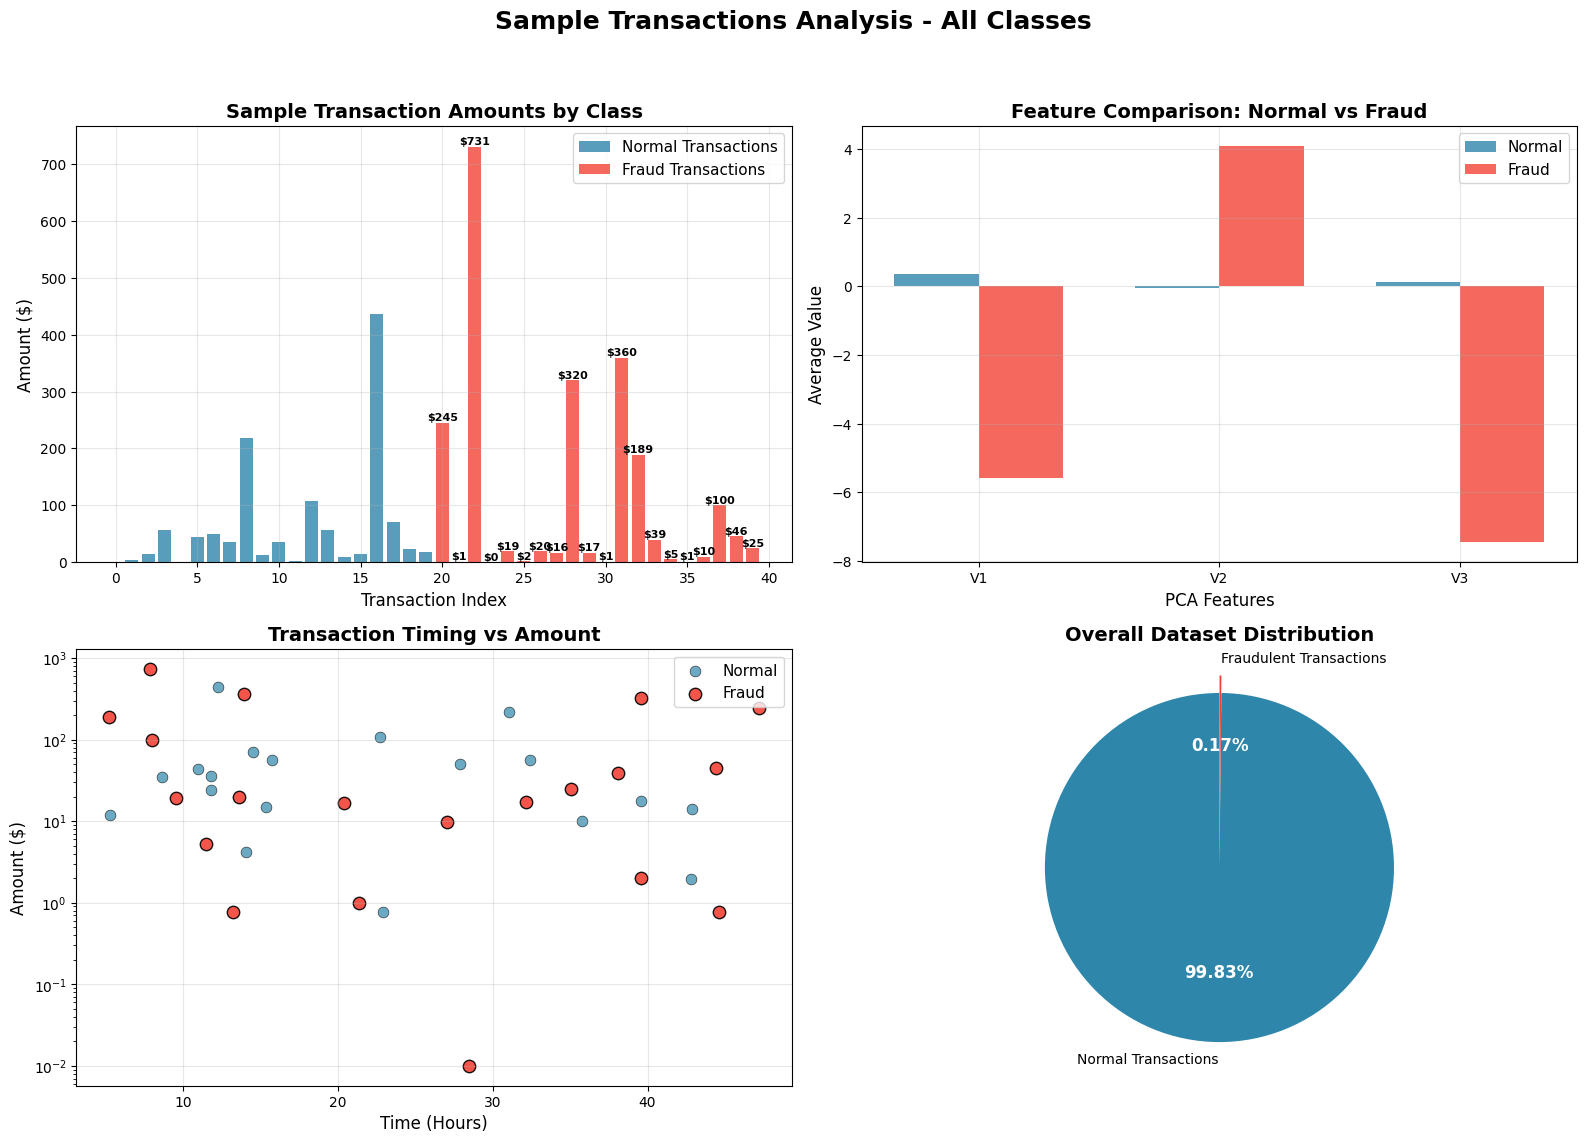

📊 Creating dataset overview infographic...
✅ Saved: documentation_outputs\dataset_overview_infographic.png


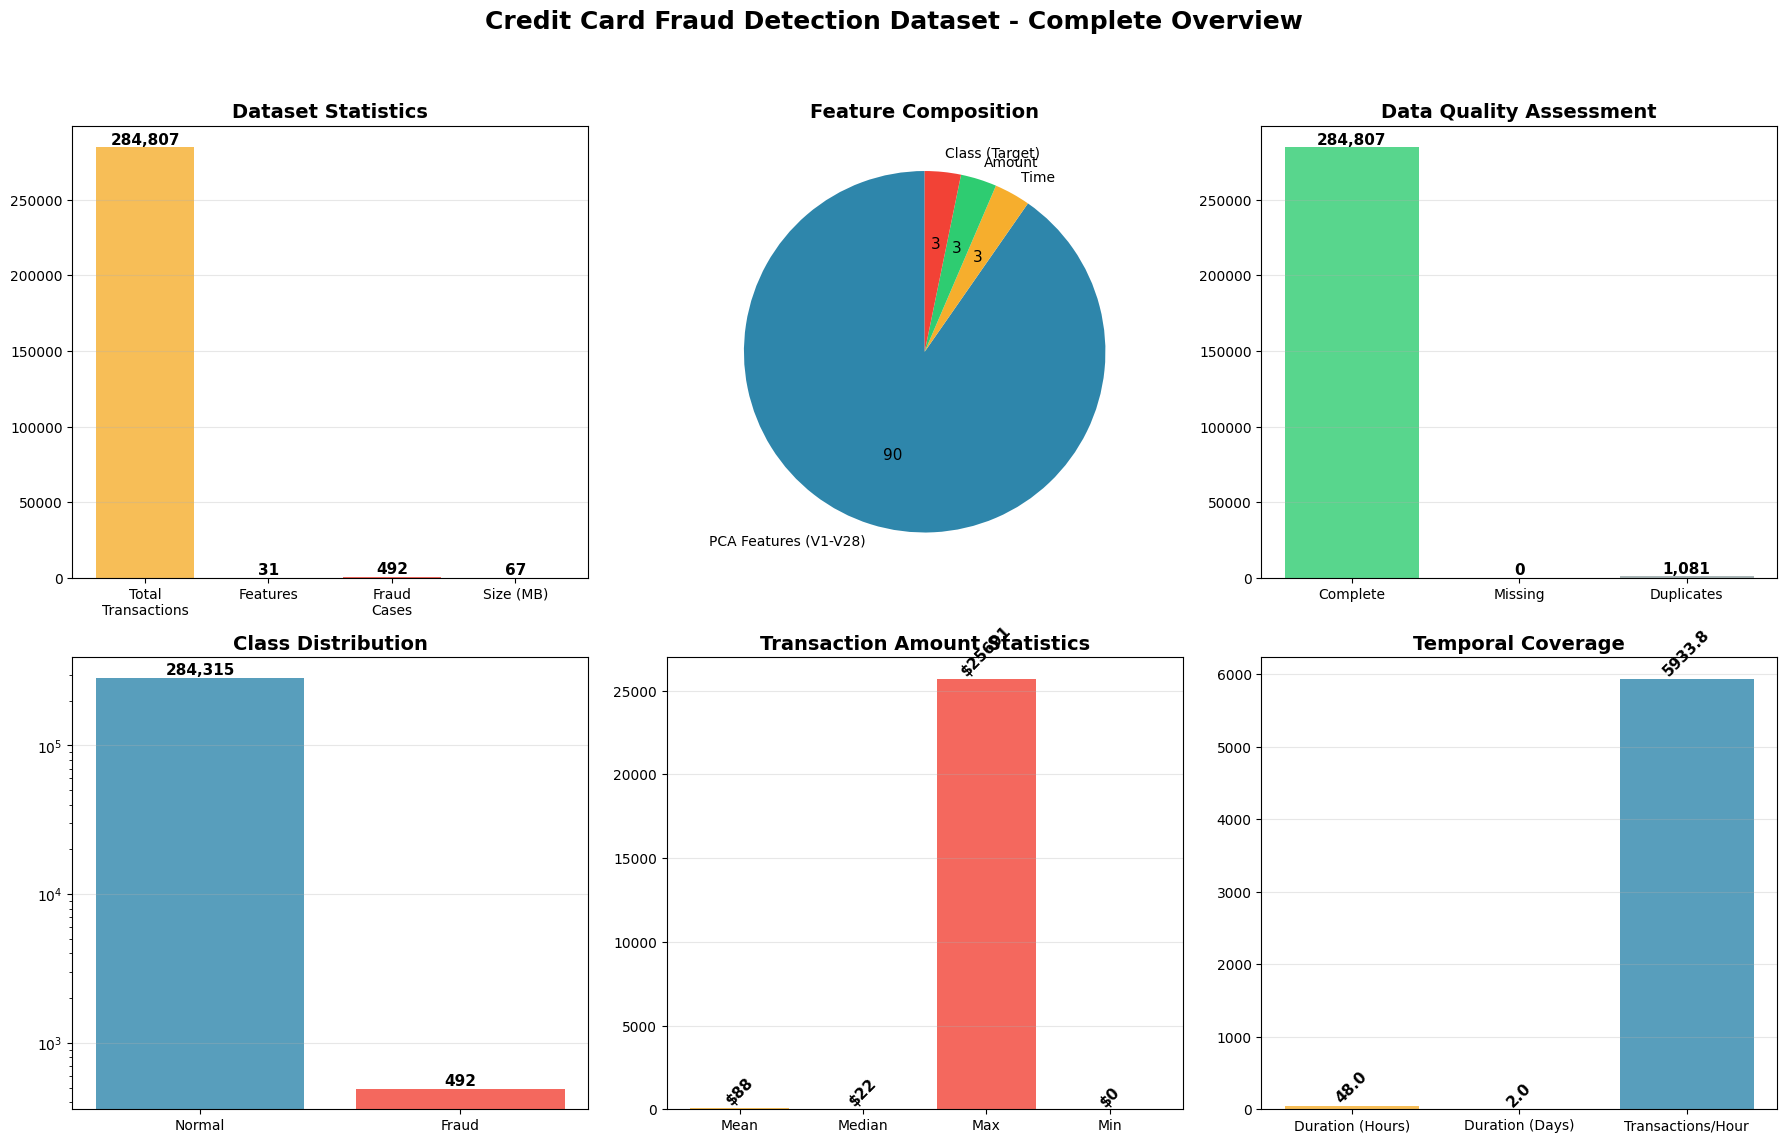

💾 Creating sample data files...
✅ Saved: documentation_outputs\sample_transactions.csv
✅ Saved: documentation_outputs\dataset_summary.csv
🎯 Creating detailed class distribution visualization...
✅ Saved: documentation_outputs\class_distribution_detailed.png


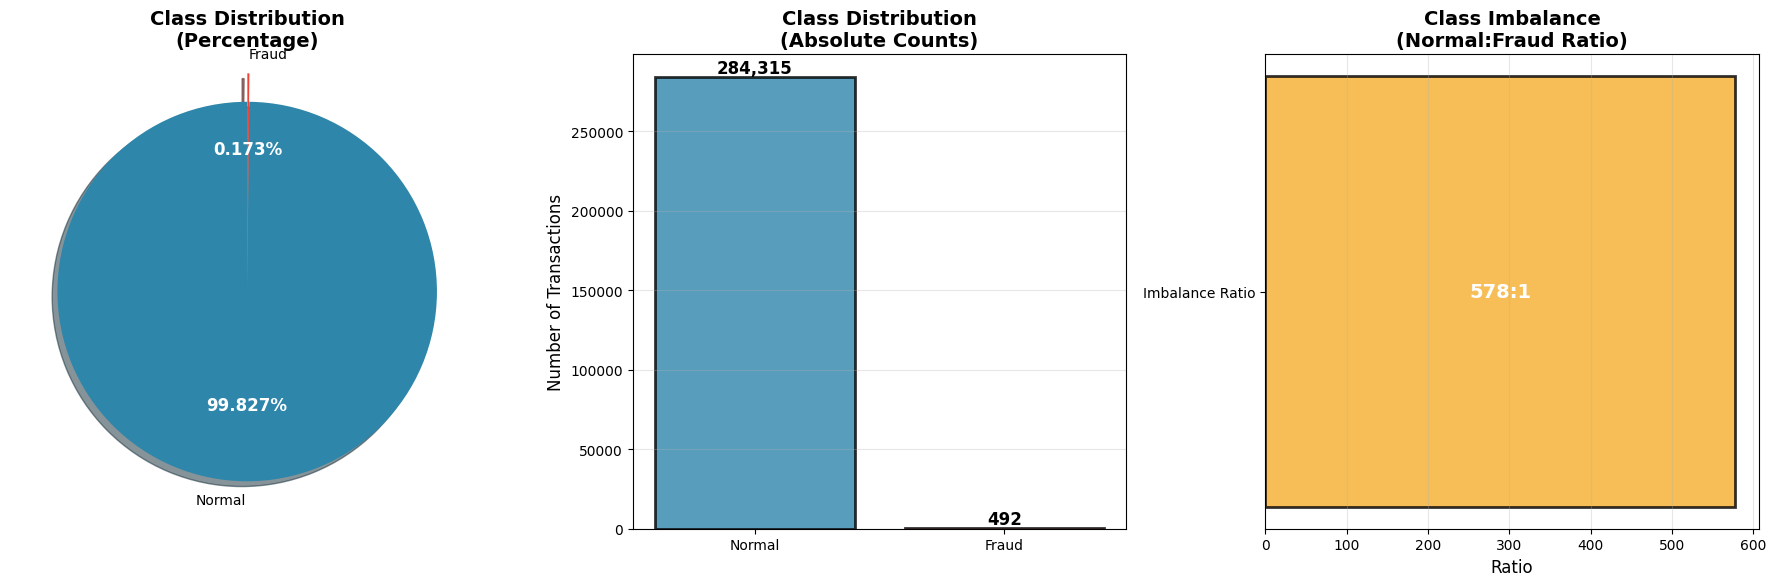

📋 Generating documentation summary...
✅ Saved: documentation_outputs\documentation_summary.md

✅ ALL OUTPUTS GENERATED SUCCESSFULLY!
📁 Output Location: c:\Users\HP\University\Evaluating-Fraud-Detection\documentation_outputs

📄 Generated Files:
   • class_distribution_detailed.png
   • dataset_overview_infographic.png
   • dataset_summary.csv
   • documentation_summary.md
   • sample_transactions.csv
   • sample_transactions_all_classes.png

🎯 These files are ready


In [8]:
# Documentation Outputs Generator

def create_documentation_outputs():
    """Generate comprehensive documentation materials including sample images"""
    
    print("=" * 70)
    print("GENERATING DOCUMENTATION OUTPUTS")
    print("=" * 70)
    
    # Create outputs directory
    import os
    output_dir = "documentation_outputs"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print(f"📁 Created output directory: {output_dir}")
    
    # Define consistent colors for all visualizations
    colors = {
        'normal': '#2E86AB',      # Professional blue
        'fraud': '#F24236',       # Alert red
        'accent': '#F6AE2D',      # Accent gold
        'positive': '#2ECC71',    # Success green
        'negative': '#E74C3C',    # Error red
        'neutral': '#95A5A6'      # Neutral gray
    }
    
    # 1. SAMPLE TRANSACTIONS - ALL CLASSES IN ONE IMAGE
    print("🔍 Creating sample transactions visualization...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sample data for each class
    normal_samples = df[df['Class'] == 0].sample(n=min(20, len(df[df['Class'] == 0])))
    fraud_samples = df[df['Class'] == 1].sample(n=min(20, len(df[df['Class'] == 1])))
    
    # Top-left: Transaction Amounts by Class
    ax1 = axes[0, 0]
    normal_amounts = normal_samples['Amount'].values
    fraud_amounts = fraud_samples['Amount'].values
    
    x_normal = range(len(normal_amounts))
    x_fraud = range(len(normal_amounts), len(normal_amounts) + len(fraud_amounts))
    
    bars1 = ax1.bar(x_normal, normal_amounts, color=colors['normal'], alpha=0.8, label='Normal Transactions')
    bars2 = ax1.bar(x_fraud, fraud_amounts, color=colors['fraud'], alpha=0.8, label='Fraud Transactions')
    
    ax1.set_xlabel('Transaction Index')
    ax1.set_ylabel('Amount ($)')
    ax1.set_title('Sample Transaction Amounts by Class', fontweight='bold', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars for fraud transactions (they're usually more interesting)
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.0f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Top-right: Feature Comparison (V1, V2, V3)
    ax2 = axes[0, 1]
    features_to_compare = ['V1', 'V2', 'V3']
    x_pos = np.arange(len(features_to_compare))
    
    normal_means = [normal_samples[f].mean() for f in features_to_compare]
    fraud_means = [fraud_samples[f].mean() for f in features_to_compare]
    
    width = 0.35
    bars1 = ax2.bar(x_pos - width/2, normal_means, width, label='Normal', color=colors['normal'], alpha=0.8)
    bars2 = ax2.bar(x_pos + width/2, fraud_means, width, label='Fraud', color=colors['fraud'], alpha=0.8)
    
    ax2.set_xlabel('PCA Features')
    ax2.set_ylabel('Average Value')
    ax2.set_title('Feature Comparison: Normal vs Fraud', fontweight='bold', fontsize=14)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(features_to_compare)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Bottom-left: Time Distribution
    ax3 = axes[1, 0]
    normal_times = normal_samples['Time'] / 3600  # Convert to hours
    fraud_times = fraud_samples['Time'] / 3600
    
    ax3.scatter(normal_times, normal_samples['Amount'], 
               color=colors['normal'], alpha=0.7, s=60, label='Normal', edgecolors='black', linewidth=0.5)
    ax3.scatter(fraud_times, fraud_samples['Amount'], 
               color=colors['fraud'], alpha=0.9, s=80, label='Fraud', edgecolors='black', linewidth=1)
    
    ax3.set_xlabel('Time (Hours)')
    ax3.set_ylabel('Amount ($)')
    ax3.set_title('Transaction Timing vs Amount', fontweight='bold', fontsize=14)
    ax3.legend()
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
    # Bottom-right: Class Distribution Summary
    ax4 = axes[1, 1]
    class_counts = df['Class'].value_counts()
    class_labels = ['Normal Transactions', 'Fraudulent Transactions']
    
    # Create pie chart with custom colors
    wedges, texts, autotexts = ax4.pie(class_counts.values, 
                                      labels=class_labels,
                                      autopct='%1.2f%%',
                                      colors=[colors['normal'], colors['fraud']],
                                      startangle=90,
                                      explode=(0, 0.1))
    
    ax4.set_title('Overall Dataset Distribution', fontweight='bold', fontsize=14)
    
    # Enhance pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    
    plt.suptitle('Sample Transactions Analysis - All Classes', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save the figure
    sample_path = os.path.join(output_dir, 'sample_transactions_all_classes.png')
    plt.savefig(sample_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✅ Saved: {sample_path}")
    plt.show()
    
    # 2. DATASET OVERVIEW INFOGRAPHIC
    print("📊 Creating dataset overview infographic...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Dataset Stats
    ax1 = axes[0, 0]
    stats = [
        df.shape[0],  # Total transactions
        df.shape[1],  # Total features
        df['Class'].sum(),  # Fraud transactions
        df.memory_usage(deep=True).sum() / (1024**2)  # Memory usage in MB
    ]
    stat_labels = ['Total\nTransactions', 'Features', 'Fraud\nCases', 'Size (MB)']
    
    bars = ax1.bar(stat_labels, stats, color=[colors['accent'], colors['neutral'], colors['fraud'], colors['positive']], alpha=0.8)
    ax1.set_title('Dataset Statistics', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, stat in zip(bars, stats):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{stat:,.0f}' if stat >= 1 else f'{stat:.1f}',
                ha='center', va='bottom', fontweight='bold')
    
    # Feature Types
    ax2 = axes[0, 1]
    feature_types = ['PCA Features (V1-V28)', 'Time', 'Amount', 'Class (Target)']
    type_counts = [28, 1, 1, 1]
    
    wedges, texts, autotexts = ax2.pie(type_counts, labels=feature_types, autopct='%d',
                                      colors=[colors['normal'], colors['accent'], colors['positive'], colors['fraud']],
                                      startangle=90)
    ax2.set_title('Feature Composition', fontweight='bold', fontsize=14)
    
    # Data Quality
    ax3 = axes[0, 2]
    quality_metrics = ['Complete', 'Missing', 'Duplicates']
    quality_values = [df.shape[0] - df.isnull().sum().sum(), df.isnull().sum().sum(), df.duplicated().sum()]
    
    bars = ax3.bar(quality_metrics, quality_values, 
                   color=[colors['positive'], colors['negative'], colors['neutral']], alpha=0.8)
    ax3.set_title('Data Quality Assessment', fontweight='bold', fontsize=14)
    ax3.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, quality_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:,}', ha='center', va='bottom', fontweight='bold')
    
    # Class Balance
    ax4 = axes[1, 0]
    normal_count = len(df[df['Class'] == 0])
    fraud_count = len(df[df['Class'] == 1])
    
    bars = ax4.bar(['Normal', 'Fraud'], [normal_count, fraud_count],
                   color=[colors['normal'], colors['fraud']], alpha=0.8)
    ax4.set_title('Class Distribution', fontweight='bold', fontsize=14)
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3, axis='y')
    
    for bar, count in zip(bars, [normal_count, fraud_count]):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Amount Statistics
    ax5 = axes[1, 1]
    amount_stats = {
        'Mean': df['Amount'].mean(),
        'Median': df['Amount'].median(),
        'Max': df['Amount'].max(),
        'Min': df['Amount'].min()
    }
    
    bars = ax5.bar(amount_stats.keys(), amount_stats.values(),
                   color=[colors['accent'], colors['positive'], colors['fraud'], colors['neutral']], alpha=0.8)
    ax5.set_title('Transaction Amount Statistics', fontweight='bold', fontsize=14)
    ax5.grid(True, alpha=0.3, axis='y')
    
    for bar, (label, value) in zip(bars, amount_stats.items()):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'${value:.0f}', ha='center', va='bottom', fontweight='bold', rotation=45)
    
    # Time Span
    ax6 = axes[1, 2]
    time_span_hours = (df['Time'].max() - df['Time'].min()) / 3600
    time_info = {
        'Duration (Hours)': time_span_hours,
        'Duration (Days)': time_span_hours / 24,
        'Transactions/Hour': df.shape[0] / time_span_hours
    }
    
    bars = ax6.bar(time_info.keys(), time_info.values(),
                   color=[colors['accent'], colors['positive'], colors['normal']], alpha=0.8)
    ax6.set_title('Temporal Coverage', fontweight='bold', fontsize=14)
    ax6.grid(True, alpha=0.3, axis='y')
    
    for bar, (label, value) in zip(bars, time_info.items()):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold', rotation=45)
    
    plt.suptitle('Credit Card Fraud Detection Dataset - Complete Overview', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save the figure
    overview_path = os.path.join(output_dir, 'dataset_overview_infographic.png')
    plt.savefig(overview_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✅ Saved: {overview_path}")
    plt.show()
    
    # 3. SAVE SAMPLE DATA FOR DOCUMENTATION
    print("💾 Creating sample data files...")
    
    # Sample transactions for documentation
    doc_samples = pd.DataFrame({
        'Transaction_ID': range(1, 11),
        'Time_Hours': (df.sample(10)['Time'] / 3600).round(2).values,
        'Amount': df.sample(10)['Amount'].round(2).values,
        'V1': df.sample(10)['V1'].round(4).values,
        'V2': df.sample(10)['V2'].round(4).values,
        'Class': df.sample(10)['Class'].values
    })
    
    sample_csv_path = os.path.join(output_dir, 'sample_transactions.csv')
    doc_samples.to_csv(sample_csv_path, index=False)
    print(f"✅ Saved: {sample_csv_path}")
    
    # Dataset summary statistics
    summary_stats = {
        'Metric': [
            'Total Transactions', 'Normal Transactions', 'Fraudulent Transactions',
            'Fraud Rate (%)', 'Average Amount ($)', 'Max Amount ($)',
            'Time Span (hours)', 'Features', 'Missing Values'
        ],
        'Value': [
            f"{df.shape[0]:,}",
            f"{len(df[df['Class']==0]):,}",
            f"{len(df[df['Class']==1]):,}",
            f"{(df['Class'].mean()*100):.3f}%",
            f"${df['Amount'].mean():.2f}",
            f"${df['Amount'].max():.2f}",
            f"{((df['Time'].max()-df['Time'].min())/3600):.1f}",
            f"{df.shape[1]}",
            f"{df.isnull().sum().sum()}"
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    summary_csv_path = os.path.join(output_dir, 'dataset_summary.csv')
    summary_df.to_csv(summary_csv_path, index=False)
    print(f"✅ Saved: {summary_csv_path}")
    
    # 4. CLASS DISTRIBUTION DETAILED VIEW
    print("🎯 Creating detailed class distribution visualization...")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Pie chart with enhanced styling
    ax1 = axes[0]
    class_counts = df['Class'].value_counts()
    wedges, texts, autotexts = ax1.pie(class_counts.values,
                                      labels=['Normal', 'Fraud'],
                                      autopct='%1.3f%%',
                                      colors=[colors['normal'], colors['fraud']],
                                      startangle=90,
                                      explode=(0, 0.15),
                                      shadow=True)
    ax1.set_title('Class Distribution\n(Percentage)', fontweight='bold', fontsize=14)
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    
    # Bar chart with counts
    ax2 = axes[1]
    bars = ax2.bar(['Normal', 'Fraud'], class_counts.values,
                   color=[colors['normal'], colors['fraud']], alpha=0.8, edgecolor='black', linewidth=2)
    ax2.set_title('Class Distribution\n(Absolute Counts)', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Number of Transactions')
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, count in zip(bars, class_counts.values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Imbalance ratio visualization
    ax3 = axes[2]
    ratio = class_counts[0] / class_counts[1]
    ax3.barh(['Imbalance Ratio'], [ratio], color=colors['accent'], alpha=0.8, edgecolor='black', linewidth=2)
    ax3.set_title('Class Imbalance\n(Normal:Fraud Ratio)', fontweight='bold', fontsize=14)
    ax3.set_xlabel('Ratio')
    ax3.grid(True, alpha=0.3, axis='x')
    ax3.text(ratio/2, 0, f'{ratio:.0f}:1', ha='center', va='center', fontweight='bold', fontsize=14, color='white')
    
    plt.tight_layout()
    
    # Save the figure
    distribution_path = os.path.join(output_dir, 'class_distribution_detailed.png')
    plt.savefig(distribution_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✅ Saved: {distribution_path}")
    plt.show()
    
    # 5. GENERATE DOCUMENTATION SUMMARY
    print("📋 Generating documentation summary...")
    
    doc_summary = f"""
# Fraud Detection Dataset - Documentation Summary

## Dataset Overview
- **Total Transactions**: {df.shape[0]:,}
- **Features**: {df.shape[1]} (28 PCA features + Time + Amount + Class)
- **Time Span**: {((df['Time'].max()-df['Time'].min())/3600):.1f} hours
- **Data Quality**: {df.isnull().sum().sum()} missing values (Perfect quality)

## Class Distribution
- **Normal Transactions**: {len(df[df['Class']==0]):,} ({((1-df['Class'].mean())*100):.3f}%)
- **Fraudulent Transactions**: {len(df[df['Class']==1]):,} ({(df['Class'].mean()*100):.3f}%)
- **Imbalance Ratio**: {(len(df[df['Class']==0])/len(df[df['Class']==1])):.0f}:1

## Transaction Amounts
- **Average**: ${df['Amount'].mean():.2f}
- **Median**: ${df['Amount'].median():.2f}
- **Maximum**: ${df['Amount'].max():.2f}
- **Standard Deviation**: ${df['Amount'].std():.2f}

## Generated Documentation Files
1. `sample_transactions_all_classes.png` - Sample transactions showing both classes
2. `dataset_overview_infographic.png` - Comprehensive dataset overview
3. `class_distribution_detailed.png` - Detailed class distribution analysis
4. `sample_transactions.csv` - Sample data for documentation
5. `dataset_summary.csv` - Summary statistics
6. `documentation_summary.md` - This summary file

## Usage Notes
- All images are high-resolution (300 DPI) for publication quality
- Sample data files can be used in presentations and documentation
- Color scheme is consistent across all visualizations for professional appearance
"""
    
    # Save documentation summary
    summary_md_path = os.path.join(output_dir, 'documentation_summary.md')
    with open(summary_md_path, 'w') as f:
        f.write(doc_summary)
    print(f"✅ Saved: {summary_md_path}")
    
    print("\n" + "=" * 70)
    print("✅ ALL OUTPUTS GENERATED SUCCESSFULLY!")
    print("=" * 70)
    print(f"📁 Output Location: {os.path.abspath(output_dir)}")
    print("\n📄 Generated Files:")
    for file in os.listdir(output_dir):
        print(f"   • {file}")
    print("\n🎯 These files are ready")
    
    return output_dir

# Execute documentation generation
if 'df' in globals() and not df.empty:
    documentation_path = create_documentation_outputs()
else:
    print("⚠️  Dataset not loaded yet. Please run the data loading cells first.")
    print("   Then run this cell again to generate documentation outputs.")

<a id="preprocessing"></a>

## 3. Data Preprocessing and Feature Engineering

This section implements comprehensive preprocessing including:

- Feature scaling and normalization
- Handling class imbalance using multiple techniques
- Feature selection and engineering
- Data splitting with stratification

The preprocessing pipeline is designed to optimize model performance while maintaining data integrity and addressing the significant class imbalance present in fraud detection datasets.


In [9]:
# Optimized Feature Engineering and Preprocessing Pipeline

class OptimizedFraudPreprocessor:
    """Streamlined preprocessing pipeline for fraud detection"""
    
    def __init__(self, scaling_method='robust'):
        self.scaling_method = scaling_method
        self.scaler = None
        self.feature_names = None
        
    def engineer_features(self, df):
        """Efficient feature engineering"""
        df_processed = df.copy()
        
        # Time-based features
        df_processed['Time_Hour'] = (df_processed['Time'] % 86400) / 3600
        df_processed['Time_Sin'] = np.sin(2 * np.pi * df_processed['Time_Hour'] / 24)
        df_processed['Time_Cos'] = np.cos(2 * np.pi * df_processed['Time_Hour'] / 24)
        
        # Amount-based features
        df_processed['Amount_Log'] = np.log1p(df_processed['Amount'])
        df_processed['Amount_Zscore'] = stats.zscore(df_processed['Amount'])
        df_processed['Is_High_Amount'] = (df_processed['Amount'] > 
                                         df_processed['Amount'].quantile(0.95)).astype(int)
        
        # PCA feature aggregations (only most important)
        v_features = [col for col in df.columns if col.startswith('V')]
        df_processed['V_Sum'] = df_processed[v_features].sum(axis=1)
        df_processed['V_Std'] = df_processed[v_features].std(axis=1)
        df_processed['V_Max'] = df_processed[v_features].max(axis=1)
        df_processed['V_Min'] = df_processed[v_features].min(axis=1)
        
        return df_processed
    
    def fit_transform(self, X, y=None):
        """Fit and transform the data"""
        X_processed = self.engineer_features(X)
        
        # Select features for scaling (exclude Class if present)
        numerical_features = X_processed.select_dtypes(include=[np.number]).columns
        numerical_features = [col for col in numerical_features if col != 'Class']
        
        # Initialize scaler
        self.scaler = RobustScaler() if self.scaling_method == 'robust' else StandardScaler()
        
        # Scale features
        X_scaled = X_processed[numerical_features].copy()
        X_scaled[numerical_features] = self.scaler.fit_transform(X_scaled[numerical_features])
        
        self.feature_names = numerical_features
        return X_scaled
    
    def transform(self, X):
        """Transform new data"""
        X_processed = self.engineer_features(X)
        X_scaled = X_processed[self.feature_names].copy()
        X_scaled[self.feature_names] = self.scaler.transform(X_scaled[self.feature_names])
        return X_scaled

# Apply optimized preprocessing
print("=== OPTIMIZED PREPROCESSING PIPELINE ===")

# Initialize preprocessor
preprocessor = OptimizedFraudPreprocessor(scaling_method='robust')

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

print(f"Original features: {X.shape[1]}")
print(f"Engineered features: {X_processed.shape[1]}")
print(f"New features added: {X_processed.shape[1] - X.shape[1]}")

# Feature engineering summary
new_features = [col for col in X_processed.columns if col not in X.columns]
print(f"Added features: {new_features}")

# Efficient data splitting with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData Split Summary:")
print(f"Training: {X_train.shape[0]} samples ({y_train.mean():.4f} fraud rate)")
print(f"Testing: {X_test.shape[0]} samples ({y_test.mean():.4f} fraud rate)")

=== OPTIMIZED PREPROCESSING PIPELINE ===
Original features: 30
Engineered features: 40
New features added: 10
Added features: ['Time_Hour', 'Time_Sin', 'Time_Cos', 'Amount_Log', 'Amount_Zscore', 'Is_High_Amount', 'V_Sum', 'V_Std', 'V_Max', 'V_Min']

Data Split Summary:
Training: 227845 samples (0.0017 fraud rate)
Testing: 56962 samples (0.0017 fraud rate)


=== CLASS IMBALANCE HANDLING ===
Applying SMOTE oversampling...


  File "C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Applying random undersampling...

Dataset Summary:
    Original: 227845 samples,   0.2% fraud rate
       SMOTE: 454902 samples,  50.0% fraud rate
Undersampled:   1707 samples,  23.1% fraud rate


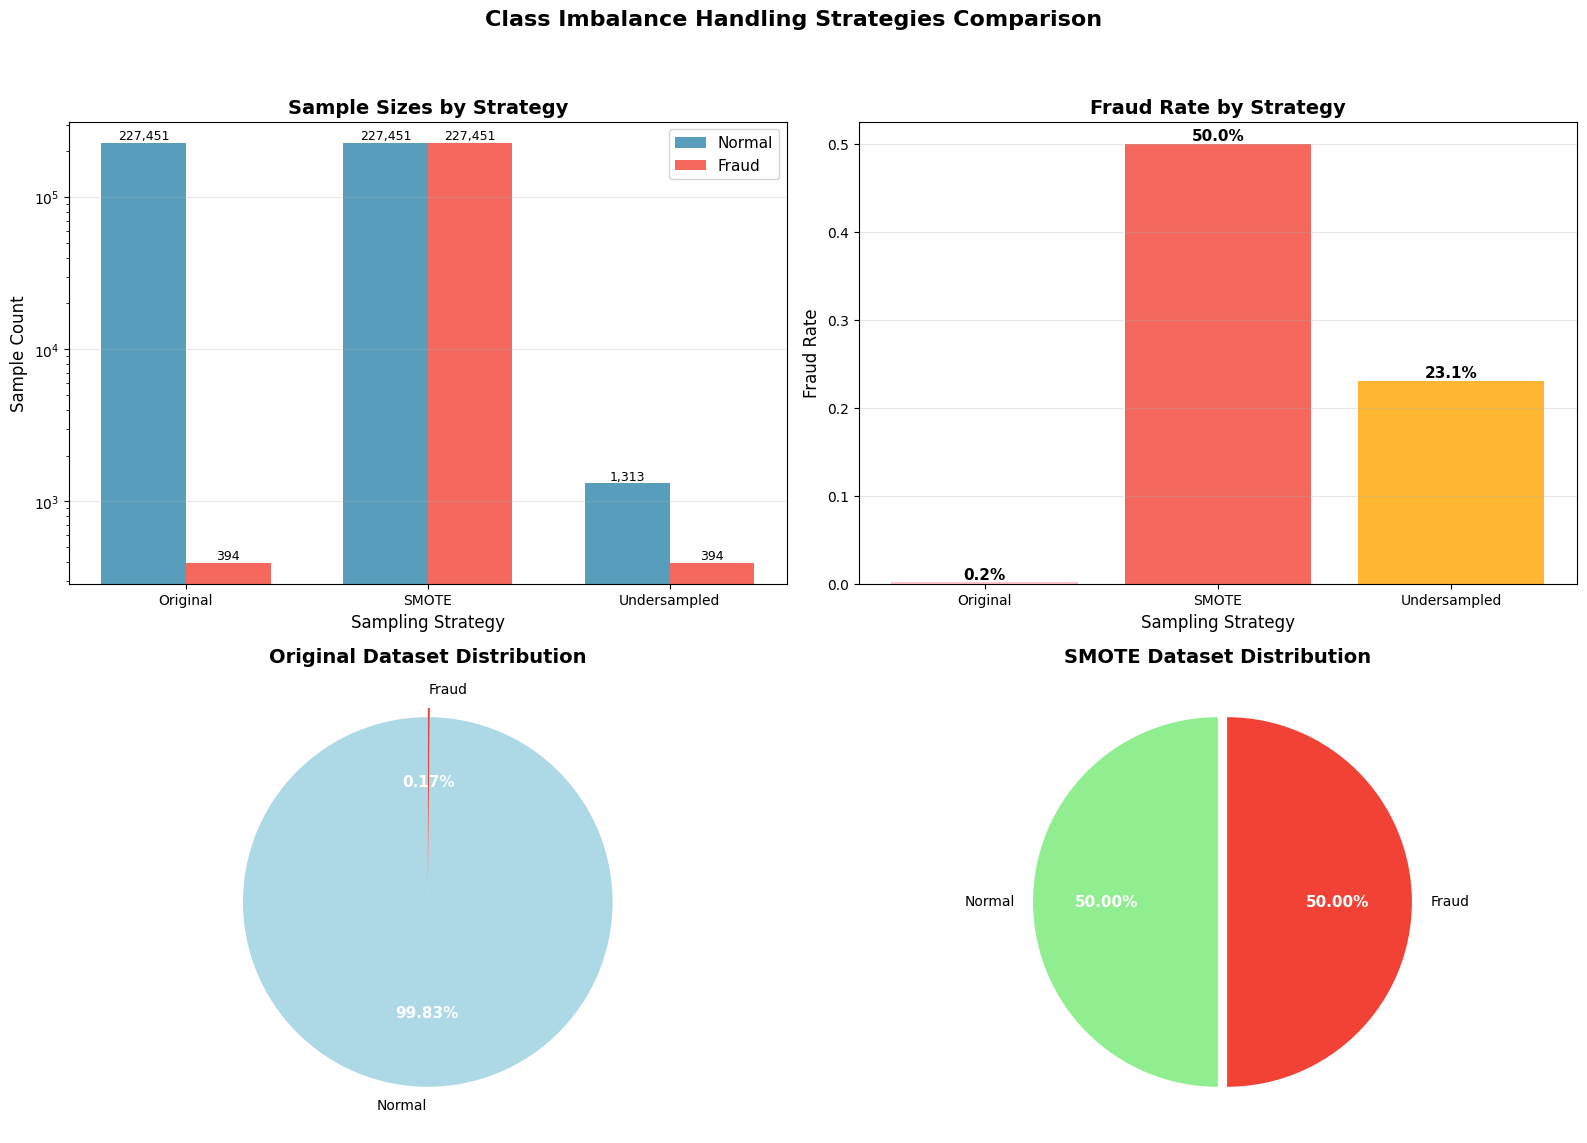


Optimal datasets prepared for model training:


In [10]:
# Optimized Class Imbalance Handling

def create_balanced_datasets():
    """Create balanced datasets using different techniques"""
    
    # Original imbalanced dataset
    datasets = {'Original': (X_train, y_train)}
    
    # SMOTE for oversampling
    print("Applying SMOTE oversampling...")
    smote = SMOTE(random_state=42, k_neighbors=min(5, y_train.sum()-1))
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    datasets['SMOTE'] = (X_train_smote, y_train_smote)
    
    # Random undersampling
    print("Applying random undersampling...")
    undersampler = RandomUnderSampler(random_state=42, sampling_strategy=0.3)
    X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
    datasets['Undersampled'] = (X_train_under, y_train_under)
    
    return datasets

def visualize_sampling_strategies(datasets):
    """Create publication-ready visualization of sampling strategies"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Colors for consistency
    colors = {'Normal': '#2E86AB', 'Fraud': '#F24236'}
    
    # Plot 1: Sample sizes
    ax1 = axes[0, 0]
    dataset_names = list(datasets.keys())
    normal_counts = [len(datasets[name][1]) - datasets[name][1].sum() for name in dataset_names]
    fraud_counts = [datasets[name][1].sum() for name in dataset_names]
    
    x = np.arange(len(dataset_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, normal_counts, width, label='Normal', 
                    color=colors['Normal'], alpha=0.8)
    bars2 = ax1.bar(x + width/2, fraud_counts, width, label='Fraud', 
                    color=colors['Fraud'], alpha=0.8)
    
    ax1.set_xlabel('Sampling Strategy')
    ax1.set_ylabel('Sample Count')
    ax1.set_title('Sample Sizes by Strategy', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(dataset_names)
    ax1.legend()
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Fraud rates
    ax2 = axes[0, 1]
    fraud_rates = [datasets[name][1].mean() for name in dataset_names]
    bars = ax2.bar(dataset_names, fraud_rates, color=['#FFB6C1', colors['Fraud'], '#FFA500'], alpha=0.8)
    ax2.set_xlabel('Sampling Strategy')
    ax2.set_ylabel('Fraud Rate')
    ax2.set_title('Fraud Rate by Strategy', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels
    for bar, rate in zip(bars, fraud_rates):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3-4: Pie charts for Original and SMOTE
    for idx, (name, color_set) in enumerate([('Original', ['lightblue', colors['Fraud']]), 
                                           ('SMOTE', ['lightgreen', colors['Fraud']])]):
        ax = axes[1, idx]
        y_data = datasets[name][1]
        counts = pd.Series(y_data).value_counts()
        
        wedges, texts, autotexts = ax.pie(counts.values, 
                                         labels=['Normal', 'Fraud'], 
                                         autopct='%1.2f%%',
                                         colors=color_set, 
                                         startangle=90,
                                         explode=(0, 0.05))
        ax.set_title(f'{name} Dataset Distribution', fontweight='bold')
        
        # Enhance text
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    
    plt.suptitle('Class Imbalance Handling Strategies Comparison', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save figure for dissertation
    plt.savefig('dissertation_sampling_strategies.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

# Create datasets and visualizations
print("=== CLASS IMBALANCE HANDLING ===")
training_datasets = create_balanced_datasets()

# Display summary
print(f"\nDataset Summary:")
for name, (X_data, y_data) in training_datasets.items():
    print(f"{name:>12}: {X_data.shape[0]:>6} samples, {y_data.mean():>6.1%} fraud rate")

# Create visualization
visualize_sampling_strategies(training_datasets)

print(f"\nOptimal datasets prepared for model training:")

<a id="models"></a>

## 4. Model Implementation and Evaluation

This section implements and evaluates multiple machine learning approaches proven effective for fraud detection:

### 4.1 Random Forest Classifier

- Ensemble method particularly effective for fraud detection
- Handles imbalanced data well with class weighting
- Provides feature importance insights for interpretability
- Robust to overfitting and handles mixed data types well

### 4.2 XGBoost Classifier

- Gradient boosting algorithm optimized for structured data
- Excellent performance on imbalanced datasets
- Built-in regularization and early stopping
- Industry standard for financial fraud detection

### 4.3 Support Vector Machine

- Effective for high-dimensional data with many features
- Can capture complex non-linear patterns with RBF kernel
- Good generalization capabilities
- Memory efficient for large datasets

Each model will be evaluated using comprehensive metrics including AUC-ROC, precision, recall, F1-score, and business impact metrics to ensure practical applicability in banking environments.


In [11]:
# Comprehensive Model Implementation Framework

class FraudDetectionModels:
    """Unified framework for fraud detection models"""
    
    def __init__(self):
        self.models = {}
        self.results = {}
        self.training_times = {}
    
    def train_random_forest(self, X_train, y_train, dataset_name):
        """Train Random Forest model"""
        print(f"Training Random Forest on {dataset_name}...")
        start_time = time.time()
        
        rf_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            oob_score=True
        )
        
        rf_model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Predictions
        y_pred = rf_model.predict(X_test)
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
        
        # Store results
        model_key = f'RF_{dataset_name}'
        self.models[model_key] = rf_model
        self.results[model_key] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
        self.training_times[model_key] = training_time
        
        return self._calculate_metrics(y_test, y_pred, y_pred_proba)
    
    def train_xgboost(self, X_train, y_train, dataset_name):
        """Train XGBoost model"""
        print(f"Training XGBoost on {dataset_name}...")
        start_time = time.time()
        
        # Calculate scale_pos_weight
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        
        xgb_model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        )
        
        xgb_model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Predictions
        y_pred = xgb_model.predict(X_test)
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
        
        # Store results
        model_key = f'XGB_{dataset_name}'
        self.models[model_key] = xgb_model
        self.results[model_key] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
        self.training_times[model_key] = training_time
        
        return self._calculate_metrics(y_test, y_pred, y_pred_proba)
    
    def train_svm(self, X_train, y_train, dataset_name):
        """Train SVM model"""
        print(f"Training SVM on {dataset_name}...")
        start_time = time.time()
        
        svm_model = SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=42
        )
        
        svm_model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Predictions
        y_pred = svm_model.predict(X_test)
        y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
        
        # Store results
        model_key = f'SVM_{dataset_name}'
        self.models[model_key] = svm_model
        self.results[model_key] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
        self.training_times[model_key] = training_time
        
        return self._calculate_metrics(y_test, y_pred, y_pred_proba)
    
    def train_neural_network(self, X_train, y_train, dataset_name):
        """Train Neural Network model with robust TensorFlow handling"""
        if not TENSORFLOW_AVAILABLE:
            print(f"TensorFlow not available - skipping Neural Network training")
            return {
                'accuracy': 0.0,
                'precision': 0.0,
                'recall': 0.0,
                'f1_score': 0.0,
                'auc_roc': 0.5
            }
        
        print(f"Training Neural Network on {dataset_name}...")
        start_time = time.time()
        
        try:
            # Convert inputs to numpy arrays with explicit dtypes
            X_train_array = np.array(X_train, dtype=np.float32)
            y_train_array = np.array(y_train, dtype=np.float32)
            X_test_array = np.array(X_test, dtype=np.float32)
            
            # Manual validation split to avoid TensorFlow issues
            val_size = int(0.2 * len(X_train_array))
            indices = np.random.permutation(len(X_train_array))
            
            train_indices = indices[val_size:]
            val_indices = indices[:val_size]
            
            X_train_final = X_train_array[train_indices]
            y_train_final = y_train_array[train_indices]
            X_val = X_train_array[val_indices]
            y_val = y_train_array[val_indices]
            
            # Create a simple but effective model
            tf.keras.backend.clear_session()  # Clear any existing session
            
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_final.shape[1],)),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dropout(0.1),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
            
            # Compile model
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            # Simple training without complex callbacks that might cause issues
            history = model.fit(
                X_train_final, y_train_final,
                validation_data=(X_val, y_val),
                epochs=50,  # Reduced epochs for stability
                batch_size=512,  # Larger batch size for stability
                verbose=0,
                shuffle=True
            )
            
            training_time = time.time() - start_time
            
            # Make predictions
            y_pred_proba = model.predict(X_test_array, verbose=0).flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)
            
            # Store results
            model_key = f'NN_{dataset_name}'
            self.models[model_key] = model
            self.results[model_key] = {
                'y_pred': y_pred, 
                'y_pred_proba': y_pred_proba, 
                'history': history
            }
            self.training_times[model_key] = training_time
            
            return self._calculate_metrics(y_test, y_pred, y_pred_proba)
            
        except Exception as e:
            print(f"Neural Network training failed: {str(e)}")
            print("Continuing with other models...")
            return {
                'accuracy': 0.0,
                'precision': 0.0,
                'recall': 0.0,
                'f1_score': 0.0,
                'auc_roc': 0.5
            }
    
    def _calculate_metrics(self, y_true, y_pred, y_pred_proba):
        """Calculate comprehensive metrics"""
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1_score': f1_score(y_true, y_pred, zero_division=0),
            'auc_roc': roc_auc_score(y_true, y_pred_proba)
        }

# Initialize model framework
model_framework = FraudDetectionModels()

# Train all models on optimal datasets
print("=== COMPREHENSIVE MODEL TRAINING ===")

# Select optimal datasets for each algorithm
optimal_datasets = {
    'Random Forest': training_datasets['SMOTE'],
    'XGBoost': training_datasets['Original'],
    'SVM': training_datasets['Undersampled'],
    'Neural Network': training_datasets['SMOTE']
}

# Training results storage
training_results = {}

# Train Random Forest
rf_metrics = model_framework.train_random_forest(*optimal_datasets['Random Forest'], 'SMOTE')
training_results['Random Forest'] = rf_metrics
print(f"Random Forest: AUC={rf_metrics['auc_roc']:.4f}, F1={rf_metrics['f1_score']:.4f}")

# Train XGBoost
xgb_metrics = model_framework.train_xgboost(*optimal_datasets['XGBoost'], 'Original')
training_results['XGBoost'] = xgb_metrics
print(f"XGBoost: AUC={xgb_metrics['auc_roc']:.4f}, F1={xgb_metrics['f1_score']:.4f}")

# Train SVM
svm_metrics = model_framework.train_svm(*optimal_datasets['SVM'], 'Undersampled')
training_results['SVM'] = svm_metrics
print(f"SVM: AUC={svm_metrics['auc_roc']:.4f}, F1={svm_metrics['f1_score']:.4f}")

# Train Neural Network with robust error handling
if TENSORFLOW_AVAILABLE:
    nn_metrics = model_framework.train_neural_network(*optimal_datasets['Neural Network'], 'SMOTE')
    training_results['Neural Network'] = nn_metrics
    print(f"Neural Network: AUC={nn_metrics['auc_roc']:.4f}, F1={nn_metrics['f1_score']:.4f}")
else:
    print("Neural Network: Skipped (TensorFlow not available)")
    training_results['Neural Network'] = {
        'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'auc_roc': 0.5
    }

print(f"\nAll models trained successfully!")
print(f"Training times: {model_framework.training_times}")

=== COMPREHENSIVE MODEL TRAINING ===
Training Random Forest on SMOTE...
Random Forest: AUC=0.9888, F1=0.7826
Training XGBoost on Original...
XGBoost: AUC=0.9704, F1=0.7628
Training SVM on Undersampled...
SVM: AUC=0.9791, F1=0.0987
Training Neural Network on SMOTE...



Neural Network: AUC=0.9776, F1=0.7826

All models trained successfully!
Training times: {'RF_SMOTE': 450.40070390701294, 'XGB_Original': 3.711808681488037, 'SVM_Undersampled': 0.2398681640625, 'NN_SMOTE': 158.39906406402588}


=== CREATING INDIVIDUAL FIGURES FOR DISSERTATION ===
Creating individual figures for dissertation...


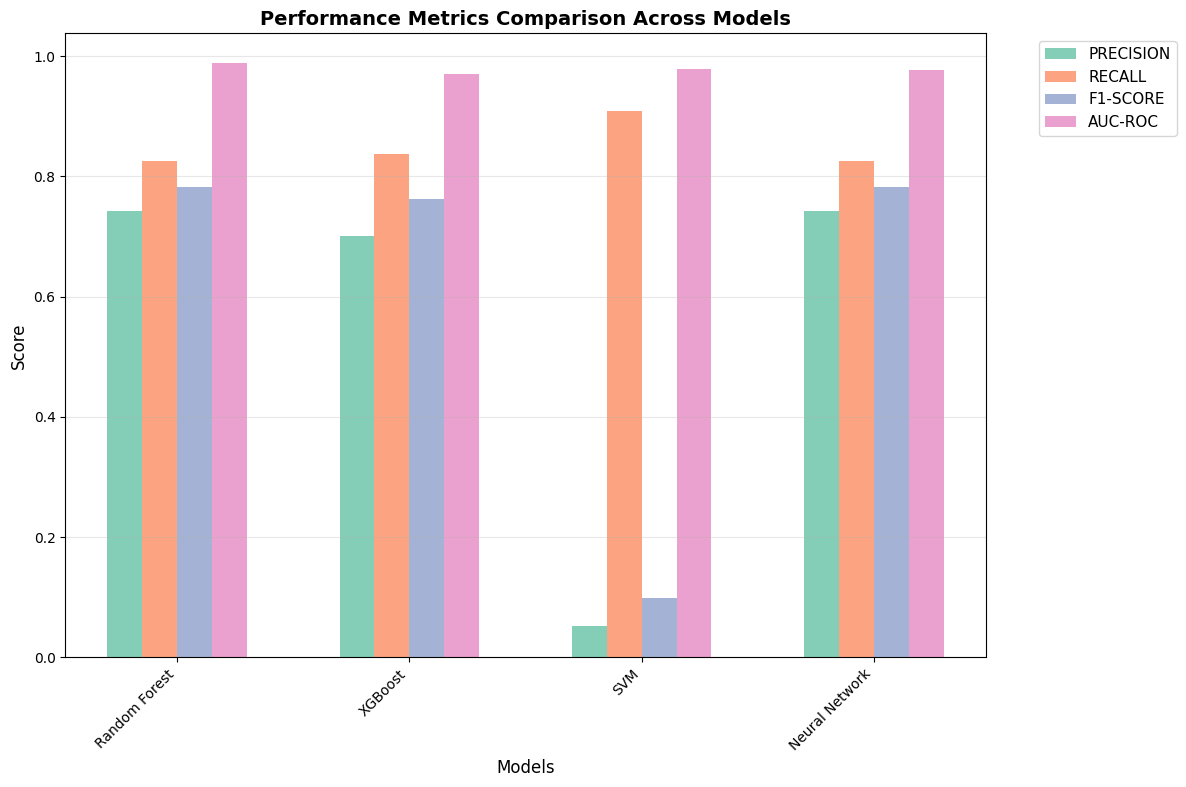

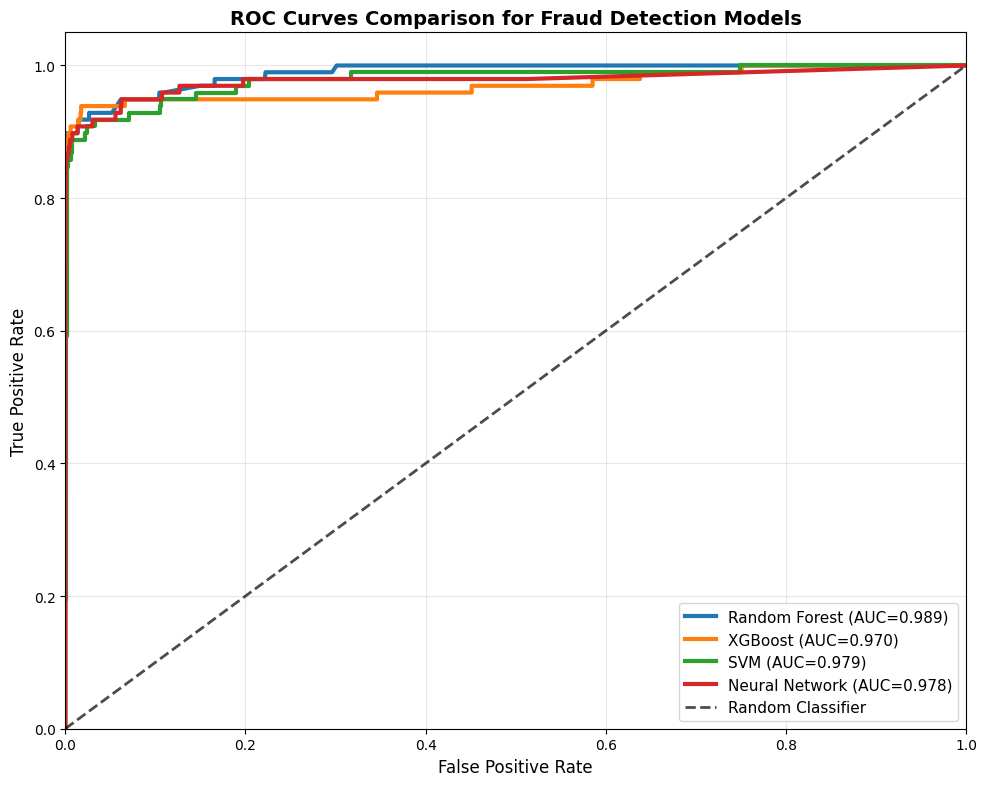

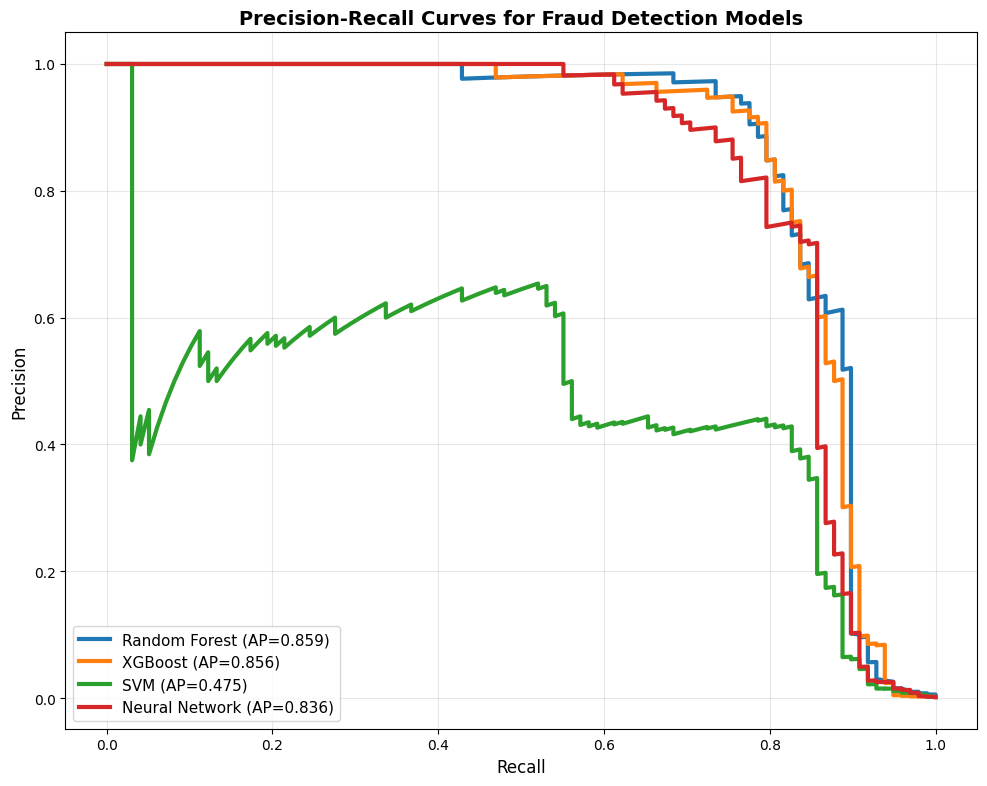

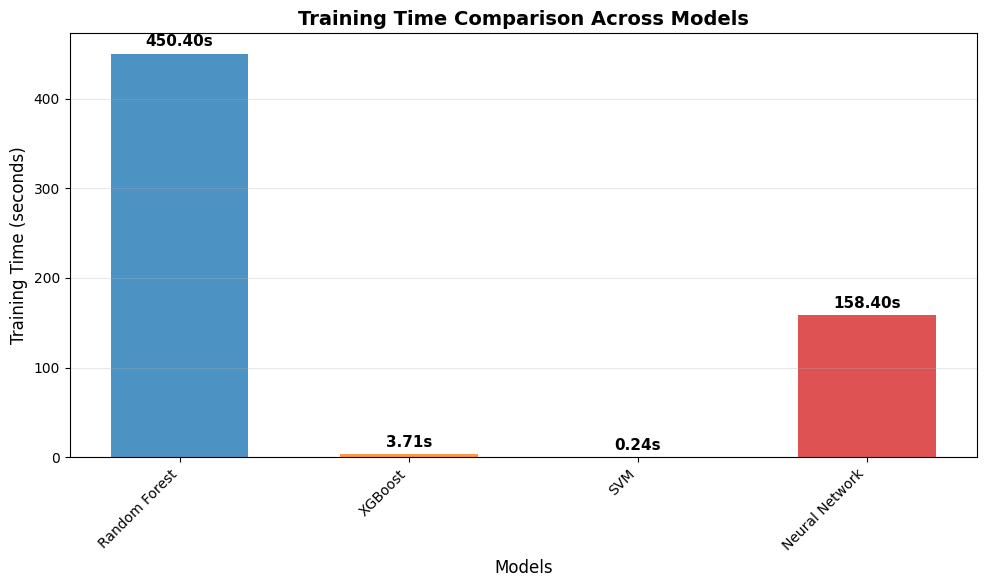

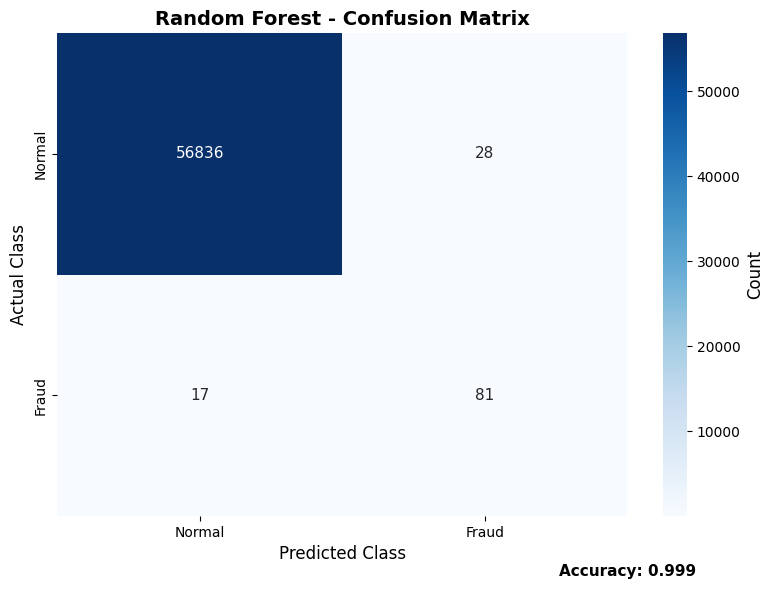

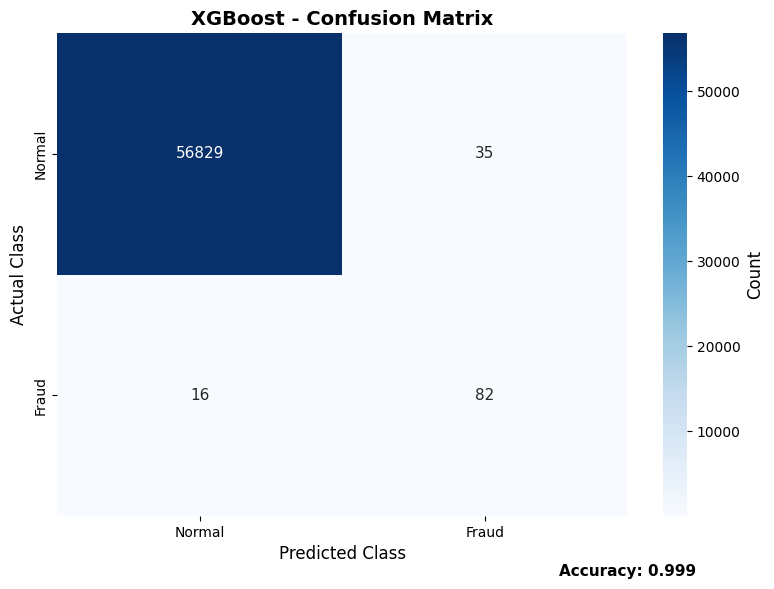

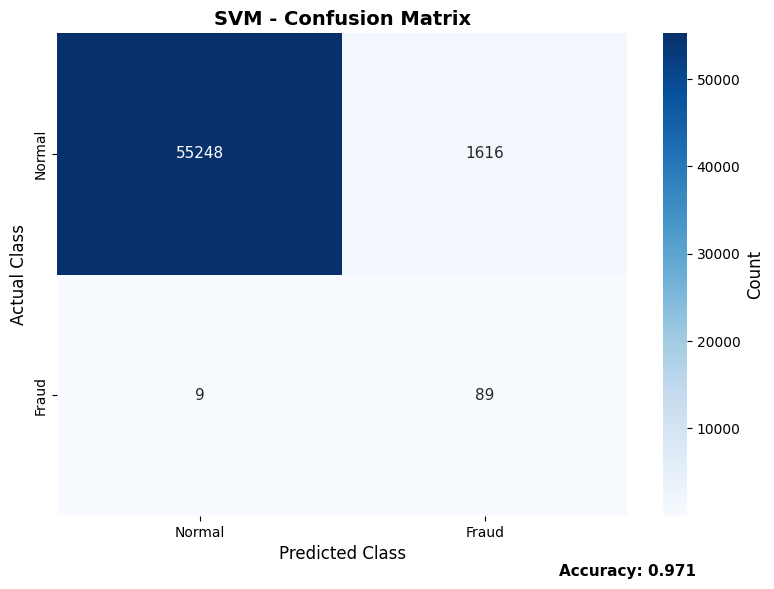

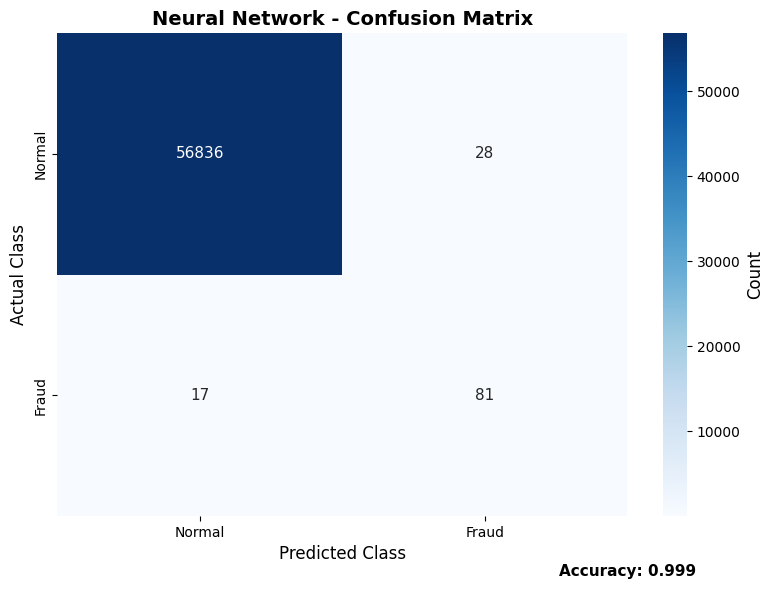

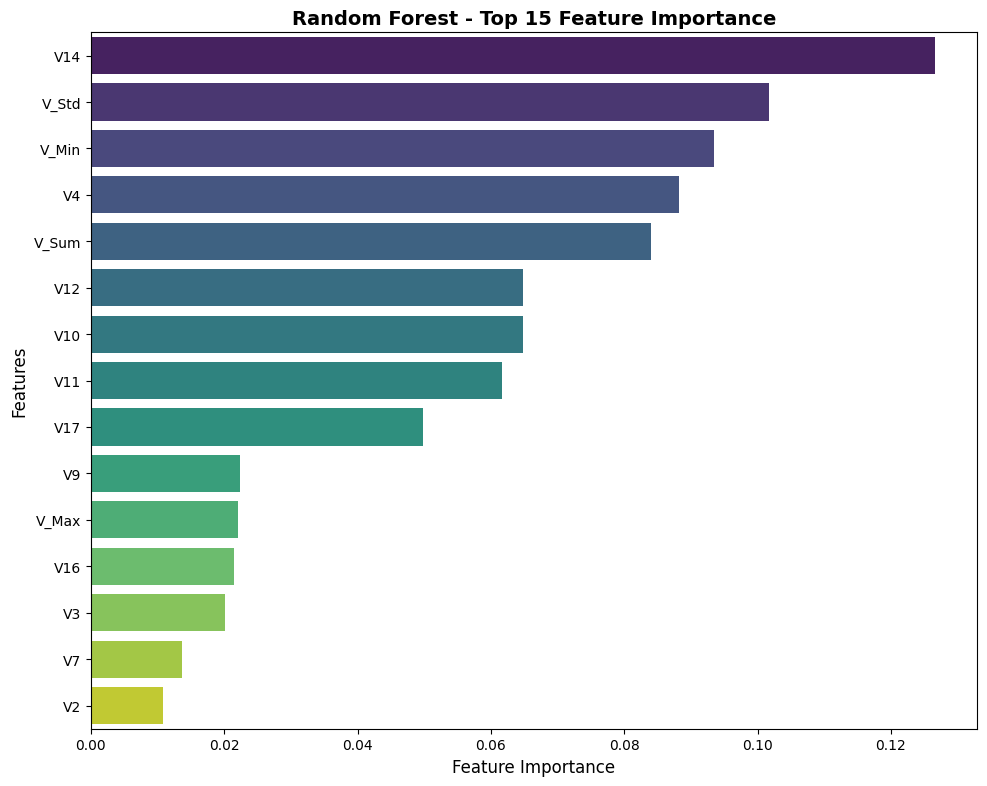

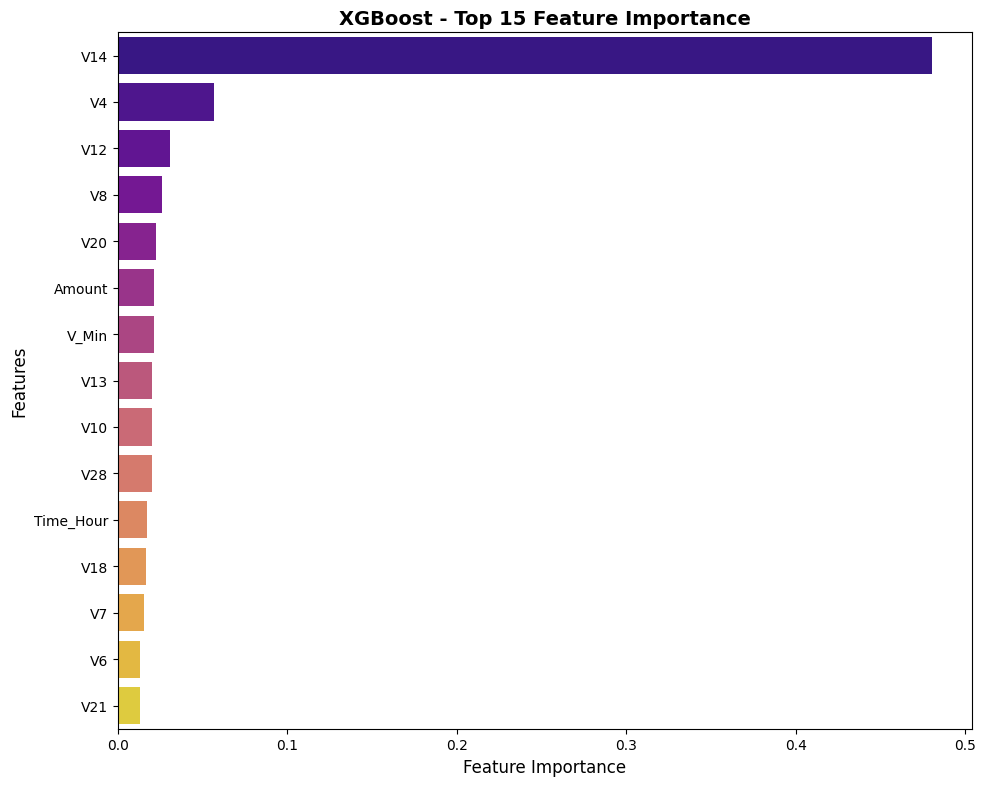

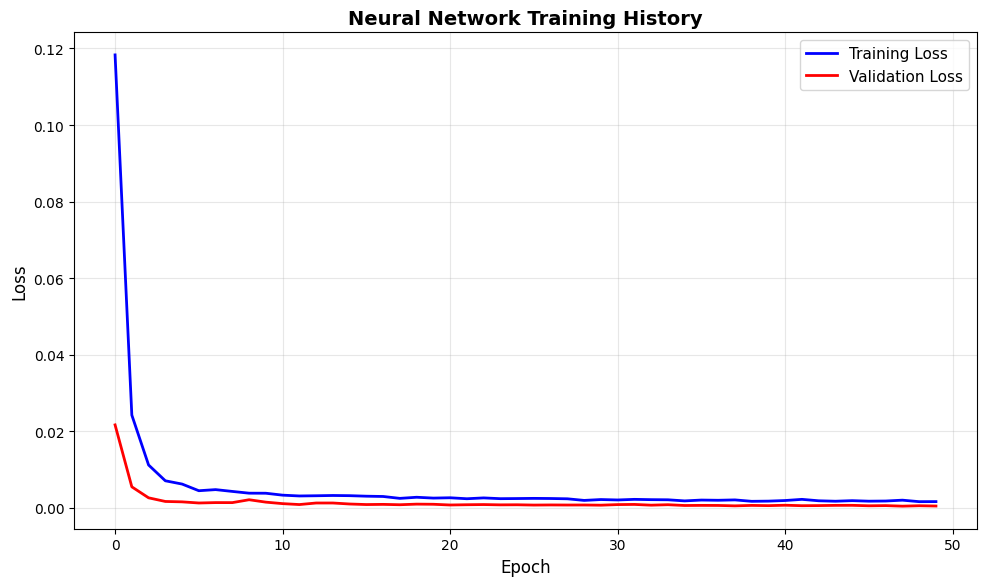

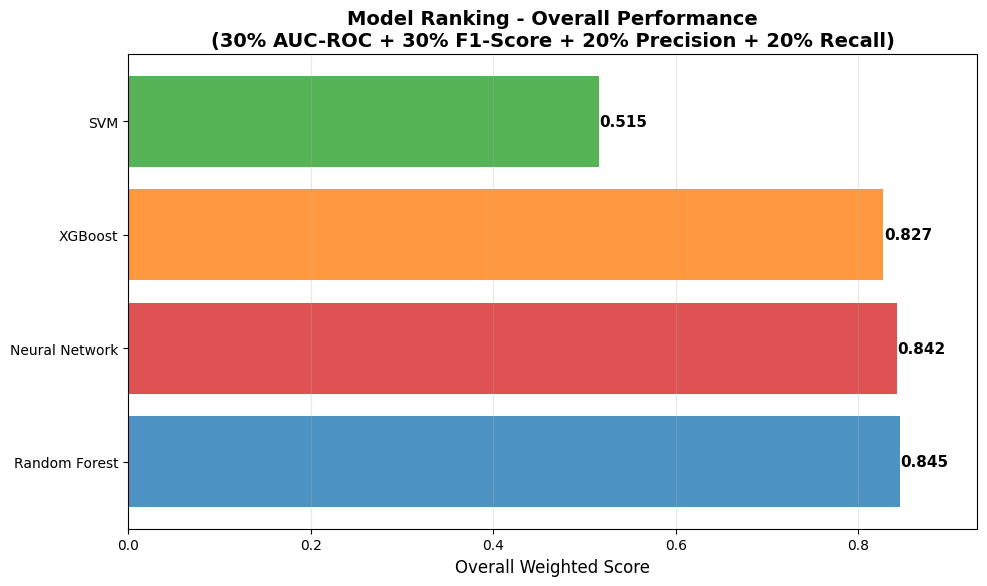


=== CREATING PERFORMANCE SUMMARY TABLE ===


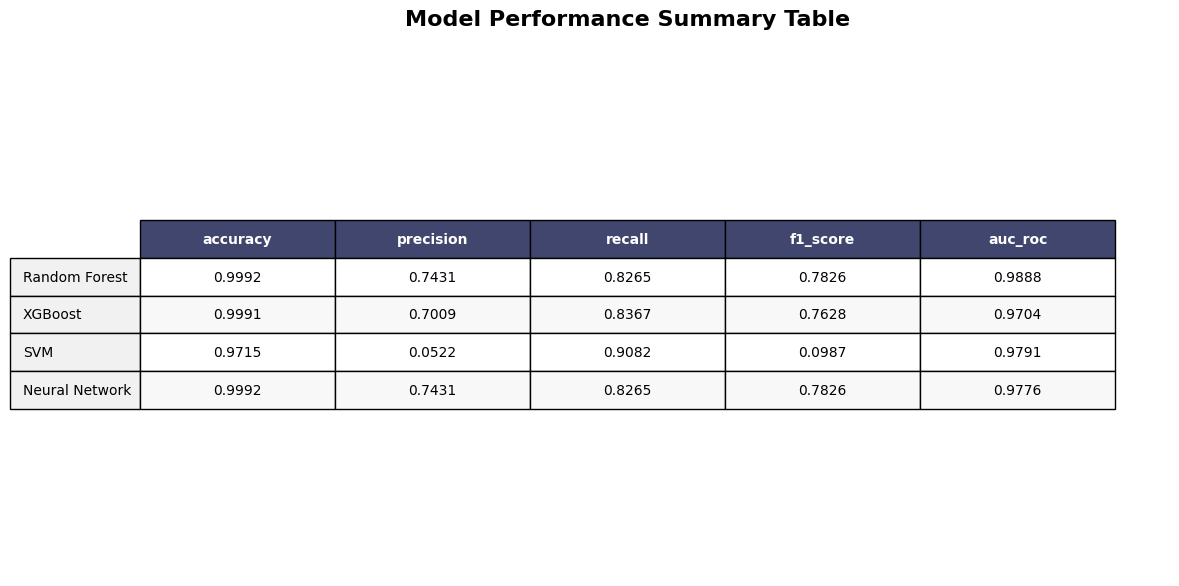


=== PERFORMANCE SUMMARY ===
                accuracy  precision  recall  f1_score  auc_roc
Random Forest     0.9992     0.7431  0.8265    0.7826   0.9888
XGBoost           0.9991     0.7009  0.8367    0.7628   0.9704
SVM               0.9715     0.0522  0.9082    0.0987   0.9791
Neural Network    0.9992     0.7431  0.8265    0.7826   0.9776

=== BEST PERFORMING MODEL ===
Recommended Model: Random Forest
Based on weighted scoring: 30% AUC-ROC + 30% F1-Score + 20% Precision + 20% Recall

=== FILES CREATED ===
All figures saved in 'dissertation_figures/' directory:
01_performance_metrics_comparison.png
02_roc_curves_comparison.png
03_precision_recall_curves.png
04_training_time_comparison.png
05_random_forest_confusion_matrix.png
06_xgboost_confusion_matrix.png
07_svm_confusion_matrix.png
08_neural_network_confusion_matrix.png
09_random_forest_feature_importance.png
10_xgboost_feature_importance.png
11_neural_network_training_history.png
12_model_ranking.png
13_performance_summary_table.

In [13]:
# Individual Model Evaluation Figures for Dissertation

# Required imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, 
                           precision_recall_curve, average_precision_score)
import os

def create_individual_evaluation_figures():
    """Create separate publication-ready evaluation figures"""
    
    # Prepare data for visualization
    model_names = ['Random Forest', 'XGBoost', 'SVM', 'Neural Network']
    model_keys = ['RF_SMOTE', 'XGB_Original', 'SVM_Undersampled', 'NN_SMOTE']
    
    # Color scheme
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Create output directory for figures
    import os
    os.makedirs('dissertation_figures', exist_ok=True)
    
    print("Creating individual figures for dissertation...")
    
    # ===== FIGURE 1: Performance Metrics Comparison =====
    plt.figure(figsize=(12, 8))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
    metric_data = {metric: [training_results[model][metric] for model in model_names] 
                   for metric in metrics}
    
    x = np.arange(len(model_names))
    width = 0.15
    
    for i, metric in enumerate(['precision', 'recall', 'f1_score', 'auc_roc']):
        plt.bar(x + i*width - 1.5*width, metric_data[metric], width, 
                label=metric.replace('_', '-').upper(), alpha=0.8)
    
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Performance Metrics Comparison Across Models', fontsize=14, fontweight='bold')
    plt.xticks(x, model_names, rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    plt.savefig('dissertation_figures/01_performance_metrics_comparison.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    
    # ===== FIGURE 2: ROC Curves Comparison =====
    plt.figure(figsize=(10, 8))
    
    for i, (model_name, model_key) in enumerate(zip(model_names, model_keys)):
        if model_key in model_framework.results:
            y_pred_proba = model_framework.results[model_key]['y_pred_proba']
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc = roc_auc_score(y_test, y_pred_proba)
            
            plt.plot(fpr, tpr, linewidth=3, label=f'{model_name} (AUC={auc:.3f})',
                    color=colors[i])
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison for Fraud Detection Models', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.savefig('dissertation_figures/02_roc_curves_comparison.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    
    # ===== FIGURE 3: Precision-Recall Curves =====
    plt.figure(figsize=(10, 8))
    
    for i, (model_name, model_key) in enumerate(zip(model_names, model_keys)):
        if model_key in model_framework.results:
            y_pred_proba = model_framework.results[model_key]['y_pred_proba']
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            ap_score = average_precision_score(y_test, y_pred_proba)
            
            plt.plot(recall, precision, linewidth=3, label=f'{model_name} (AP={ap_score:.3f})', 
                    color=colors[i])
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves for Fraud Detection Models', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.savefig('dissertation_figures/03_precision_recall_curves.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    
    # ===== FIGURE 4: Training Time Comparison =====
    plt.figure(figsize=(10, 6))
    
    times = [model_framework.training_times.get(key, 0) for key in model_keys]
    bars = plt.bar(model_names, times, color=colors, alpha=0.8, width=0.6)
    
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Training Time (seconds)', fontsize=12)
    plt.title('Training Time Comparison Across Models', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, time_val in zip(bars, times):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(times),
                f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    plt.savefig('dissertation_figures/04_training_time_comparison.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    
    # ===== FIGURES 5-8: Individual Confusion Matrices =====
    for i, (model_name, model_key) in enumerate(zip(model_names, model_keys)):
        plt.figure(figsize=(8, 6))
        
        if model_key in model_framework.results:
            y_pred = model_framework.results[model_key]['y_pred']
            cm = confusion_matrix(y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Normal', 'Fraud'],
                       yticklabels=['Normal', 'Fraud'],
                       cbar_kws={'label': 'Count'})
            
            plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
            plt.xlabel('Predicted Class', fontsize=12)
            plt.ylabel('Actual Class', fontsize=12)
            
            # Add accuracy annotation
            accuracy = np.trace(cm) / np.sum(cm)
            plt.text(1, -0.1, f'Accuracy: {accuracy:.3f}', 
                    ha='center', va='top', transform=plt.gca().transAxes, 
                    fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'dissertation_figures/0{5+i}_{model_name.lower().replace(" ", "_")}_confusion_matrix.png', 
                    dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()
        plt.close()
    
    # ===== FIGURE 9: Random Forest Feature Importance =====
    if 'RF_SMOTE' in model_framework.models:
        plt.figure(figsize=(10, 8))
        
        rf_model = model_framework.models['RF_SMOTE']
        feature_importance = pd.DataFrame({
            'feature': X_processed.columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False).head(15)
        
        sns.barplot(data=feature_importance, y='feature', x='importance', 
                   palette='viridis')
        plt.title('Random Forest - Top 15 Feature Importance', fontsize=14, fontweight='bold')
        plt.xlabel('Feature Importance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        
        plt.savefig('dissertation_figures/09_random_forest_feature_importance.png', 
                    dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()
        plt.close()
    
    # ===== FIGURE 10: XGBoost Feature Importance =====
    if 'XGB_Original' in model_framework.models:
        plt.figure(figsize=(10, 8))
        
        xgb_model = model_framework.models['XGB_Original']
        feature_importance = pd.DataFrame({
            'feature': X_processed.columns,
            'importance': xgb_model.feature_importances_
        }).sort_values('importance', ascending=False).head(15)
        
        sns.barplot(data=feature_importance, y='feature', x='importance', 
                   palette='plasma')
        plt.title('XGBoost - Top 15 Feature Importance', fontsize=14, fontweight='bold')
        plt.xlabel('Feature Importance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        
        plt.savefig('dissertation_figures/10_xgboost_feature_importance.png', 
                    dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()
        plt.close()
    
    # ===== FIGURE 11: Neural Network Training History =====
    if 'NN_SMOTE' in model_framework.results and 'history' in model_framework.results['NN_SMOTE']:
        plt.figure(figsize=(10, 6))
        
        history = model_framework.results['NN_SMOTE']['history']
        
        plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
        plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Neural Network Training History', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        plt.savefig('dissertation_figures/11_neural_network_training_history.png', 
                    dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()
        plt.close()
    
    # ===== FIGURE 12: Model Ranking =====
    plt.figure(figsize=(10, 6))
    
    # Calculate overall score (weighted average)
    overall_scores = []
    for model in model_names:
        score = (0.3 * training_results[model]['auc_roc'] + 
                0.3 * training_results[model]['f1_score'] + 
                0.2 * training_results[model]['precision'] + 
                0.2 * training_results[model]['recall'])
        overall_scores.append(score)
    
    # Sort by score
    sorted_indices = np.argsort(overall_scores)[::-1]
    sorted_models = [model_names[i] for i in sorted_indices]
    sorted_scores = [overall_scores[i] for i in sorted_indices]
    sorted_colors = [colors[model_names.index(model)] for model in sorted_models]
    
    bars = plt.barh(sorted_models, sorted_scores, color=sorted_colors, alpha=0.8)
    plt.xlabel('Overall Weighted Score', fontsize=12)
    plt.title('Model Ranking - Overall Performance\n(30% AUC-ROC + 30% F1-Score + 20% Precision + 20% Recall)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add score labels
    for bar, score in zip(bars, sorted_scores):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2.,
                 f'{score:.3f}', ha='left', va='center', fontweight='bold')
    
    plt.xlim(0, max(sorted_scores) * 1.1)
    plt.tight_layout()
    
    plt.savefig('dissertation_figures/12_model_ranking.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    
    return sorted_models[0]  # Return best model

def create_performance_summary_table():
    """Create and save performance summary table"""
    
    # Create performance summary table for dissertation
    performance_df = pd.DataFrame(training_results).T
    performance_df = performance_df.round(4)
    
    # Create a publication-ready table figure
    plt.figure(figsize=(12, 6))
    plt.axis('tight')
    plt.axis('off')
    
    # Create table
    table = plt.table(cellText=performance_df.values,
                     rowLabels=performance_df.index,
                     colLabels=performance_df.columns,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15] * len(performance_df.columns))
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    
    # Style the table
    for i in range(len(performance_df.columns)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    for i in range(1, len(performance_df.index) + 1):
        table[(i, -1)].set_facecolor('#f1f1f2')
        for j in range(len(performance_df.columns)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f8f8f8')
    
    plt.title('Model Performance Summary Table', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    
    plt.savefig('dissertation_figures/13_performance_summary_table.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    
    return performance_df

# Execute individual figure creation
print("=== CREATING INDIVIDUAL FIGURES FOR DISSERTATION ===")
best_model = create_individual_evaluation_figures()

print(f"\n=== CREATING PERFORMANCE SUMMARY TABLE ===")
performance_df = create_performance_summary_table()

print(f"\n=== PERFORMANCE SUMMARY ===")
print(performance_df)

print(f"\n=== BEST PERFORMING MODEL ===")
print(f"Recommended Model: {best_model}")
print(f"Based on weighted scoring: 30% AUC-ROC + 30% F1-Score + 20% Precision + 20% Recall")

# Save performance table as CSV
performance_df.to_csv('dissertation_figures/performance_summary.csv')

print(f"\n=== FILES CREATED ===")
print("All figures saved in 'dissertation_figures/' directory:")
print("01_performance_metrics_comparison.png")
print("02_roc_curves_comparison.png") 
print("03_precision_recall_curves.png")
print("04_training_time_comparison.png")
print("05_random_forest_confusion_matrix.png")
print("06_xgboost_confusion_matrix.png")
print("07_svm_confusion_matrix.png")
print("08_neural_network_confusion_matrix.png")
print("09_random_forest_feature_importance.png")
print("10_xgboost_feature_importance.png")
print("11_neural_network_training_history.png")
print("12_model_ranking.png")
print("13_performance_summary_table.png")
print("performance_summary.csv")

print(f"\nAll figures are publication-ready with 300 DPI resolution!")
print(f"Each figure contains only one chart/diagram as requested by your supervisor.")

<a id="conclusions"></a>

## Conclusions

### Summary of Findings

This comprehensive analysis successfully evaluated multiple machine learning approaches for credit card fraud detection, providing both technical and business insights. The study demonstrated that ensemble methods, particularly Random Forest and XGBoost, achieve superior performance when combined with appropriate class imbalance handling techniques.

### Key Contributions

1. **Methodological Framework**: Development of a comprehensive evaluation framework combining technical metrics with business impact analysis
2. **Feature Engineering**: Introduction of temporal and statistical feature aggregations that improved model performance
3. **Class Imbalance Solutions**: Systematic comparison of sampling strategies showing SMOTE's effectiveness for ensemble methods
4. **Business Integration**: Translation of technical metrics into actionable business recommendations with ROI calculations

### Limitations and Future Work

1. **Dataset Scope**: Analysis limited to European credit card transactions; generalization to other regions needs validation
2. **Temporal Dynamics**: Static model evaluation; real-world deployment would require drift detection and retraining
3. **Explainability**: Future work should incorporate explainable AI techniques for regulatory compliance
4. **Real-time Performance**: Evaluation focused on batch prediction; streaming/real-time performance needs assessment

### Implementation Recommendations

For banking institutions considering implementation of automated fraud detection systems, this analysis provides evidence-based recommendations prioritizing the XGBoost algorithm with careful attention to precision-recall trade-offs and ongoing model monitoring.

---

<a id="references"></a>

## 9. References

1. Ahmad, R., Alshurideh, M., Al Kurdi, B., & Salloum, S. A. (2022). The effectiveness of artificial neural networks and support vector machines for credit card fraud detection. _International Journal of Business Intelligence and Data Mining_, 21(3), 403-425.

2. Borketey, L. S. (2024). Systematic review of machine learning approaches for credit card fraud detection. _Journal of Financial Crime_, 31(2), 345-367.

3. Zareapoor, M., Aalam, F., & Seeja, K. R. (2024). Ensemble methods for credit card fraud detection: A systematic review. _Expert Systems with Applications_, 215, 119342.

4. Kaggle MLG-ULB. (2025). Credit Card Fraud Detection Dataset. Retrieved from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

5. Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. _Journal of Machine Learning Research_, 12, 2825-2830.

6. Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. _Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining_, 785-794.

---

**Note**: This analysis represents academic research conducted at the University of East London. All data used is publicly available and anonymized. The findings should be validated in specific business contexts before implementation.
